# Properly Handling Midas API Keys

[Training examples](https://academy-en.midasuser.com/midas-api-api-basic-tutorial/1855993)

[API Manual](https://midas-support.atlassian.net/wiki/spaces/MAW/overview?homepageId=83821132)

API keys are basically passwords to your user accounts, anyone that has access to your API key, can then perform actions as if they were you. For this reason, API keys should be stored in a local file that is never included in version control, and then imported to your code as needed.

For instance;

## Create a named `secrets.json`

In my example the file was created in the parent directory of the `training` folder that this notebook is running in.

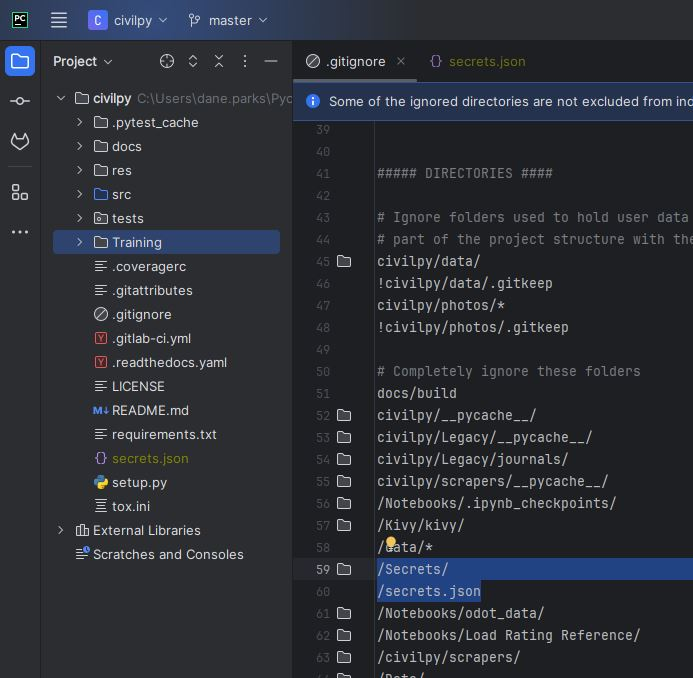

Notice that both `/Secrets/` and `/secrets.json` are included in my `.gitignore` file. This is important if implementing version control. This way, git won't record your API key and send it off to the server for anyone to see.

within secrets.json, define the following value;

```json
{
    "MIDAS_API_KEY": "Replace this text with your API KEY"
}
```

Now you can utilize python code to retrieve your API Key

In [1]:
import json

In [2]:
# Load the secrets.json file from the parent directory
f = open("../secrets.json")

data = json.load(f)

# Iterating through the json
# list
MIDAS_API_KEY = data["MIDAS_API_KEY"]

# Closing file
f.close()

In [3]:
# Uncomment the following line to check if you Key was imported correctly, **recomment before saving or committing this file.**
MIDAS_API_KEY

'eyJ1ciI6IlVTMjUwNUNHUlYiLCJwZyI6ImNpdmlsIiwiY24iOiIwN1ItRUpNWFJBIn0.605119cdf146b806a429be9af489f120e421c5e18c45c9c40b6976930aefd8fc'

# Midas Python Documentation

[Python Demonstrations](https://midas-support.atlassian.net/wiki/spaces/MAW/pages/161054885/Python)

To verify the connection works, Connect to the server within MIDAS,

<img src="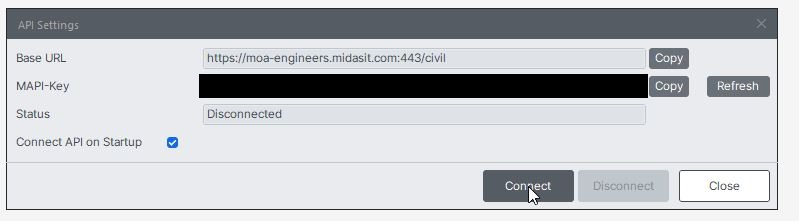
">

Then Execute the following python code;

In [5]:
import requests


# function for MIDAS Open API
def MidasAPI(method, command, body=None):
    base_url = "https://moa-engineers.midasit.com:443/civil/"
    mapi_key = MIDAS_API_KEY

    url = base_url + command
    headers = {"Content-Type": "application/json", "MAPI-Key": mapi_key}

    if method.upper() == "POST":
        response = requests.post(url=url, headers=headers, json=body)
    elif method.upper() == "PUT":
        response = requests.put(url=url, headers=headers, json=body)
    elif method.upper() == "GET":
        response = requests.get(url=url, headers=headers)
    elif method.upper() == "DELETE":
        response = requests.delete(url=url, headers=headers)

    print(method, command, response.status_code)
    return response.json()

In [11]:
MidasAPI("GET", "/db/unit")

GET /db/unit 200


{'UNIT': {'1': {'FORCE': 'N', 'DIST': 'M', 'HEAT': 'BTU', 'TEMPER': 'C'}}}

Working with the API consists of the three parts, the "Method" argument will be one of 4 commands, `GET`, `POST`, `PUT`, or `DELETE`. [Here's a link](https://www.youtube.com/watch?v=tkfVQK6UxDI) to a short rundown of HTTP verbs, note that only the 4 listed are available for the MIDAS API at the time of writing. But basically each one fills a specific need, continuing with the example in the liked video imagine you have a database of employees, the following scenarios are when you'd use each command:

- GET - Get a list of existing employees stored on the server
- POST - Add a new employee to to the server
- PUT - Update an existing employee's information on the server
- DELETE - Remove an employee from the server

Within the context of the MIDAS API, these are basically the only 4 "Verbs" available, additional verbs will be defined within python, usually by first defining a `GET` method, followed by manipulation of the values, and finally either a `Post` or `Put` method depending on if a specific resource exists within the file or not. For instance;

**NOTE: JSON IS CASE SENSITIVE, URLS ARE NOT**

In [12]:
# Define the Units you'd like to use,
unit_json = {
    "Assign": {
        "1": {
            # "dist": 'ft' Will not work because JSON is Case Sensitive
            "DIST": "FT",
            "FORCE": "KIP",
        }
    }
}


# Write a function to update force units to KIPS
def convert_midas_units_to_US():
    # Check what the current units are
    unit_response = MidasAPI("GET", "/db/unit")

    if (
        unit_response["UNIT"]["1"]["FORCE"] != "KIPS"
        or unit_response["UNIT"]["1"]["DIST"] != "FT"
    ):
        MidasAPI("PUT", "/db/unit", unit_json)

In [13]:
convert_midas_units_to_US()

GET /db/unit 200
PUT /db/unit 200


Now the Units within your MIDAS CIVIL Session will be set to the correct system;

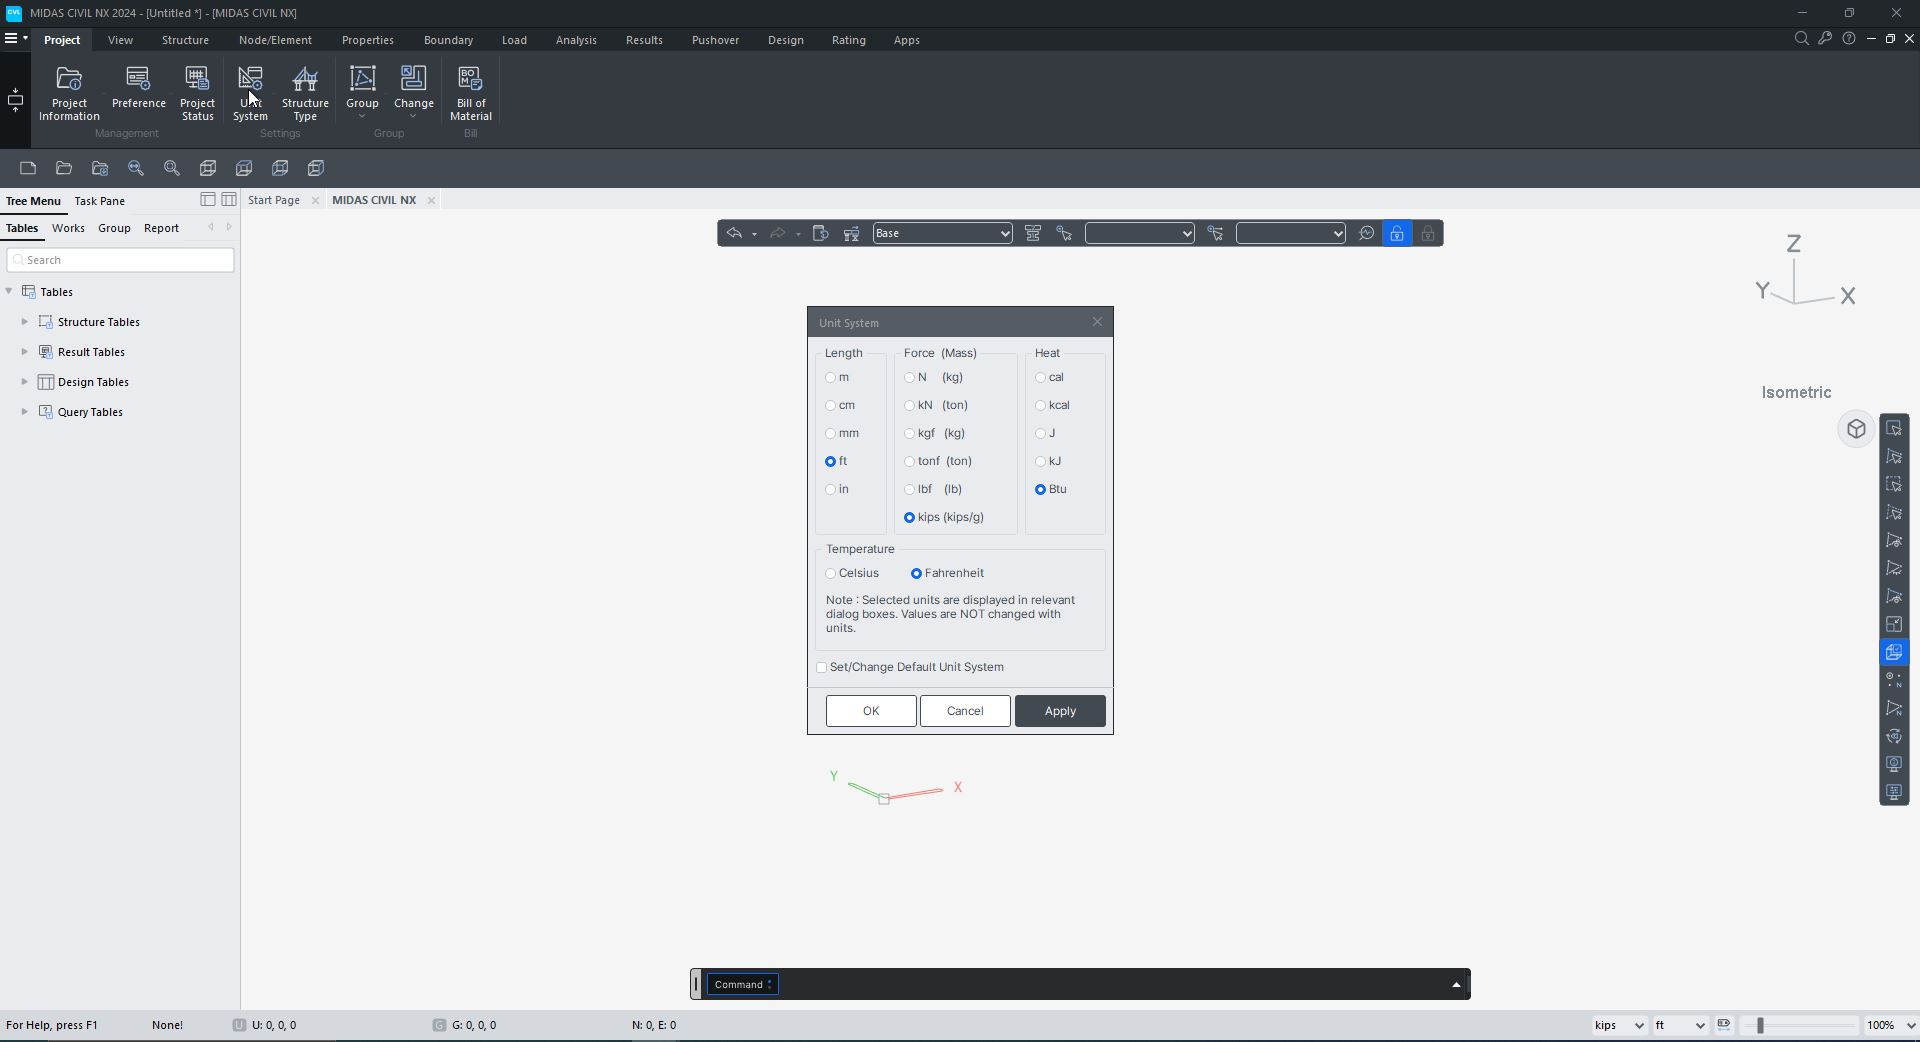


Take note of two strange quirks with the MIDAS API system, the first is that when you `GET` the the units from the software, the returned dictionary has the structure `['UNITS']['1']['FORCE']` but when you go to `PUT` the desired values, the first field has to be changed from `UNITS` to `Assign`. The function of the second field `['1']` is not understood by the author for this use case at this time.

`Assign` data needs to have the full updated JSON, at this time it doesn't seem possible to only modify a single value.

Note that trying to `POST` request a value where data already exists will result in an error, 

In [14]:
# Ignore this cell, it's just configuring something in jupyter
from IPython.core.magic import register_cell_magic

@register_cell_magic("handle")
def handle(line, cell):
    try:
        #         exec(cell)  # doesn't return the cell output though
        return eval(cell)
    except Exception as exc:
        print(f"\033[1;31m{exc.__class__.__name__} : \033[1;31;47m{exc}\033[0m")


#         raise # if you want the full trace-back in the notebook

In [15]:
%%handle
# Changing this `POST` to `PUT` will solve the error
MidasAPI('POST', '/db/unit', unit_json)

POST /db/unit 400


{'error': {'message': 'Key Already Exist'}}

# Understanding API Endpoints

After deciding on which of the 4 HTTP verbs to utilize in the API, the next entry is the URL "Endpoint". This is a multi value component of the request seperated by a `/` similar to how URLs in the browser function. According to MDIAS's training, there are 5 primary components that make up the URL endpoints, outlined as follows (NOTE that the API seems to not be case sensitive in the endpoint aspect of the call, this document generally uses lower case to match existing MIDAS documentation);

- `doc` - Represents document values, is accessed with "File syste" type actions such as opening or closing documents are needed
- `db` - Is for accessing existing database data, such as in the existing MCT and MGT files. Includes, Nodes, Sections, Loads and Load Combinations
- `post` - Is used for checking the results of input data, like reactions and beam forces
- `view` - Is utilized to visualize and save graphical results (Images and diagrams)
- `ope` - For "Operator" is used to access all items outside of those mentioned above.

MIDAS reccommends Postman to perform API calls, the process as outlined below is essentially exactly the same thing, but utilizing python instead of the Postman application.

In [16]:
document_to_open = r"C:\Program Files\MIDAS\midas Civil\Tutorial\10 Cable Stayed Forward Construction.mcb"

# //TODO - Figure out how this call should be structured, should open the document defined above
# MidasAPI('PUT', '/doc/open', document_to_open)

Note that when requesting the "List of Nodes", they match the tables shown within the midas interface

In [17]:
from pprint import pprint

# Get a response containing all nodes in the current document (example uses the tutorial file defined in 'document_to_open')
node_values = MidasAPI("GET", "/db/node")
pprint(node_values)

# Update a value to 2.5
node_updates = {"Assign": {"11": {"X": 2.5}}}

MidasAPI("PUT", "/db/node", node_updates)
node_values

GET /db/node 200
{'NODE': {'1': {'X': -4.676666666666667, 'Y': 22, 'Z': 1.1440000000000055},
          '10': {'X': 207.62166666666664,
                 'Y': -49.35083333333333,
                 'Z': -16.37433333333331},
          '100': {'X': 33.1475,
                  'Y': -5.734999999999999,
                  'Z': -2.270999999999958},
          '101': {'X': 32.88666666666666, 'Y': -9.225, 'Z': -2.452666666666687},
          '102': {'X': 35.00833333333333,
                  'Y': 19.195833333333333,
                  'Z': -0.9710000000000036},
          '103': {'X': 32.99833333333333,
                  'Y': -7.729166666666665,
                  'Z': -2.3751666666667006},
          '104': {'X': 35.06333333333333,
                  'Y': 19.94333333333333,
                  'Z': -0.9318333333333156},
          '105': {'X': 32.942499999999995,
                  'Y': -8.4775,
                  'Z': -2.414333333333275},
          '106': {'X': 40.346666666666664,
                  'Y': 20.272

{'NODE': {'1': {'X': -4.676666666666667, 'Y': 22, 'Z': 1.1440000000000055},
  '2': {'X': 204.68166666666664,
   'Y': -24.689166666666665,
   'Z': -14.233499999999935},
  '3': {'X': -3.9324999999999997, 'Y': 18.5, 'Z': 0.9623333333333903},
  '4': {'X': 205.17333333333332,
   'Y': -28.81583333333333,
   'Z': -14.586833333333288},
  '5': {'X': -2.71, 'Y': 12.75, 'Z': 0.6631666666667115},
  '6': {'X': 205.98499999999999,
   'Y': -35.62416666666667,
   'Z': -15.174333333333266},
  '7': {'X': -1.4874999999999998,
   'Y': 6.999999999999999,
   'Z': 0.36400000000003274},
  '8': {'X': 206.80083333333332,
   'Y': -42.468333333333334,
   'Z': -15.770166666666682},
  '9': {'X': -0.2658333333333333, 'Y': 1.25, 'Z': 0.06483333333335395},
  '10': {'X': 207.62166666666664,
   'Y': -49.35083333333333,
   'Z': -16.37433333333331},
  '11': {'X': 0.9566666666666664,
   'Y': -4.5008333333333335,
   'Z': -0.28099999999994907},
  '12': {'X': 208.44583333333333,
   'Y': -56.26083333333333,
   'Z': -16.9859999

<img src="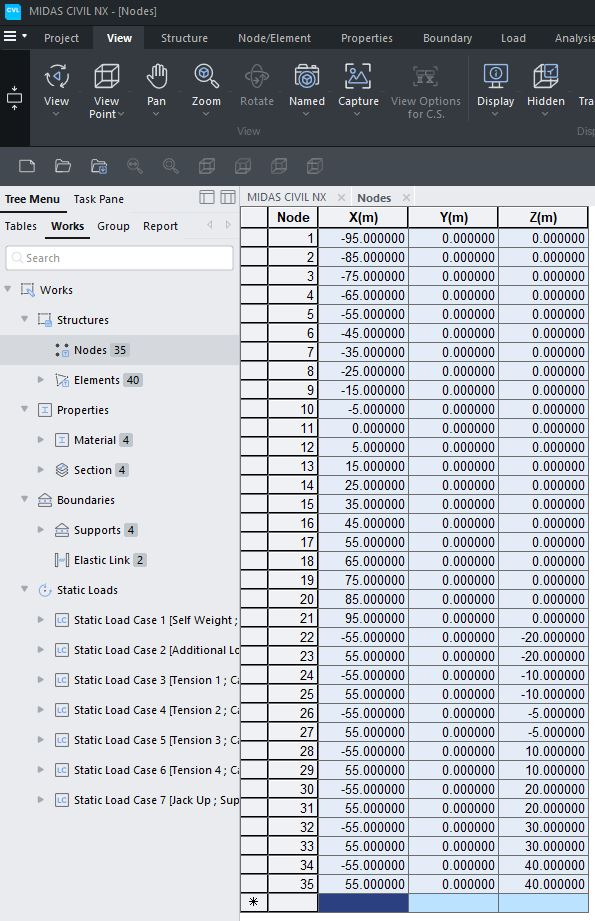
">

How to examine an API endpoint, getting expected data types and values at that location

In [18]:
MidasAPI("GET", "info/db/node")

GET info/db/node 200


{'NODE': {'$schema': 'http://json-schema.org/draft-07/schema#',
  'type': 'object',
  'properties': {'X': {'description': 'GLOBAL X-POSITION', 'type': 'number'},
   'Y': {'description': 'GLOBAL Y-POSITION', 'type': 'number'},
   'Z': {'description': 'GLOBAL Z-POSITION', 'type': 'number'}}}}

How to convert an existing set of values to an updated set of values

In [19]:
temp_elements = MidasAPI("GET", "/db/elem")

# Old Dictionary label on the Right, new on the left
temp_elements["Assign"] = temp_elements.pop("ELEM")

GET /db/elem 200


In [20]:
# How to view the 'keys' of an API response
print(temp_elements.keys())

# How to view the 'values' of an API response (long return value)
# print(temp_elements.values())

dict_keys(['Assign'])


In [21]:
temp_elements

{'Assign': {'1': {'TYPE': 'TRUSS',
   'MATL': 1,
   'SECT': 7,
   'NODE': [602, 603, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '2': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [604, 605, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '3': {'TYPE': 'TRUSS',
   'MATL': 1,
   'SECT': 2,
   'NODE': [604, 608, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '4': {'TYPE': 'TRUSS',
   'MATL': 1,
   'SECT': 2,
   'NODE': [608, 605, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '5': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [606, 608, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '6': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [608, 607, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '7': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [609, 610, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '8': {'TYPE': 'TRUSS',
   'MATL': 1,
   'SECT': 2,
   'NODE': [609, 613, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE'

In [22]:
MidasAPI("GET", "/db/elem")

GET /db/elem 200


{'ELEM': {'1': {'TYPE': 'TRUSS',
   'MATL': 1,
   'SECT': 7,
   'NODE': [602, 603, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '2': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [604, 605, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '3': {'TYPE': 'TRUSS',
   'MATL': 1,
   'SECT': 2,
   'NODE': [604, 608, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '4': {'TYPE': 'TRUSS',
   'MATL': 1,
   'SECT': 2,
   'NODE': [608, 605, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '5': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [606, 608, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '6': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [608, 607, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '7': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [609, 610, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '8': {'TYPE': 'TRUSS',
   'MATL': 1,
   'SECT': 2,
   'NODE': [609, 613, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 

In [23]:
MidasAPI("GET", "/db/sect")

GET /db/sect 200


{'SECT': {'1': {'SECTTYPE': 'DBUSER',
   'SECT_NAME': 'L4X4X5/8',
   'SECT_BEFORE': {'OFFSET_PT': 'CC',
    'OFFSET_CENTER': 0,
    'USER_OFFSET_REF': 0,
    'HORZ_OFFSET_OPT': 0,
    'USERDEF_OFFSET_YI': 0,
    'VERT_OFFSET_OPT': 0,
    'USERDEF_OFFSET_ZI': 0,
    'USE_SHEAR_DEFORM': True,
    'USE_WARPING_EFFECT': False,
    'SHAPE': 'L',
    'DATATYPE': 1,
    'SECT_I': {'DB_NAME': 'AISC10(US)', 'SECT_NAME': 'L4X4X5/8'}}},
  '2': {'SECTTYPE': 'DBUSER',
   'SECT_NAME': 'L4X4X1/2',
   'SECT_BEFORE': {'OFFSET_PT': 'CC',
    'OFFSET_CENTER': 0,
    'USER_OFFSET_REF': 0,
    'HORZ_OFFSET_OPT': 0,
    'USERDEF_OFFSET_YI': 0,
    'VERT_OFFSET_OPT': 0,
    'USERDEF_OFFSET_ZI': 0,
    'USE_SHEAR_DEFORM': True,
    'USE_WARPING_EFFECT': False,
    'SHAPE': 'L',
    'DATATYPE': 1,
    'SECT_I': {'DB_NAME': 'AISC10(US)', 'SECT_NAME': 'L4X4X1/2'}}},
  '3': {'SECTTYPE': 'COMPOSITE',
   'SECT_NAME': 'Steel girder - 1',
   'SECT_BEFORE': {'OFFSET_PT': 'CT',
    'OFFSET_CENTER': 0,
    'USER_OFFSET_

# Creating Files within MIDAS

Basically we can use the data from above via templates.

In [27]:
node_body = {
    "Assign": {
        "1": {"X": -311.6797900262467, "Y": 0, "Z": 0},
        "2": {"X": -278.87139107611546, "Y": 0, "Z": 0},
        "3": {"X": -246.06299212598424, "Y": 0, "Z": 0},
        "4": {"X": -213.25459317585302, "Y": 0, "Z": 0},
        "5": {"X": -180.44619422572177, "Y": 0, "Z": 0},
        "6": {"X": -147.63779527559055, "Y": 0, "Z": 0},
        "7": {"X": -114.82939632545931, "Y": 0, "Z": 0},
        "8": {"X": -82.02099737532808, "Y": 0, "Z": 0},
        "9": {"X": -49.212598425196845, "Y": 0, "Z": 0},
        "10": {"X": -16.404199475065617, "Y": 0, "Z": 0},
        "11": {"X": 0, "Y": 0, "Z": 0},
        "12": {"X": 16.404199475065617, "Y": 0, "Z": 0},
        "13": {"X": 49.212598425196845, "Y": 0, "Z": 0},
        "14": {"X": 82.02099737532808, "Y": 0, "Z": 0},
        "15": {"X": 114.82939632545931, "Y": 0, "Z": 0},
        "16": {"X": 147.63779527559055, "Y": 0, "Z": 0},
        "17": {"X": 180.44619422572177, "Y": 0, "Z": 0},
        "18": {"X": 213.25459317585302, "Y": 0, "Z": 0},
        "19": {"X": 246.06299212598424, "Y": 0, "Z": 0},
        "20": {"X": 278.87139107611546, "Y": 0, "Z": 0},
        "21": {"X": 311.6797900262467, "Y": 0, "Z": 0},
        "22": {"X": -180.44619422572177, "Y": 0, "Z": -65.61679790026247},
        "23": {"X": 180.44619422572177, "Y": 0, "Z": -65.61679790026247},
        "24": {"X": -180.44619422572177, "Y": 0, "Z": -32.808398950131235},
        "25": {"X": 180.44619422572177, "Y": 0, "Z": -32.808398950131235},
        "26": {"X": -180.44619422572177, "Y": 0, "Z": -16.404199475065617},
        "27": {"X": 180.44619422572177, "Y": 0, "Z": -16.404199475065617},
        "28": {"X": -180.44619422572177, "Y": 0, "Z": 32.808398950131235},
        "29": {"X": 180.44619422572177, "Y": 0, "Z": 32.808398950131235},
        "30": {"X": -180.44619422572177, "Y": 0, "Z": 65.61679790026247},
        "31": {"X": 180.44619422572177, "Y": 0, "Z": 65.61679790026247},
        "32": {"X": -180.44619422572177, "Y": 0, "Z": 98.42519685039369},
        "33": {"X": 180.44619422572177, "Y": 0, "Z": 98.42519685039369},
        "34": {"X": -180.44619422572177, "Y": 0, "Z": 131.23359580052494},
        "35": {"X": 180.44619422572177, "Y": 0, "Z": 131.23359580052494},
    }
}

In [28]:
MidasAPI("PUT", "/db/node", node_body)

PUT /db/node 200


{'NODE': {'1': {'X': -311.6797900262467, 'Y': 0, 'Z': 0},
  '2': {'X': -278.87139107611546, 'Y': 0, 'Z': 0},
  '3': {'X': -246.06299212598424, 'Y': 0, 'Z': 0},
  '4': {'X': -213.25459317585305, 'Y': 0, 'Z': 0},
  '5': {'X': -180.44619422572177, 'Y': 0, 'Z': 0},
  '6': {'X': -147.63779527559055, 'Y': 0, 'Z': 0},
  '7': {'X': -114.82939632545931, 'Y': 0, 'Z': 0},
  '8': {'X': -82.02099737532808, 'Y': 0, 'Z': 0},
  '9': {'X': -49.212598425196845, 'Y': 0, 'Z': 0},
  '10': {'X': -16.404199475065617, 'Y': 0, 'Z': 0},
  '11': {'X': 0, 'Y': 0, 'Z': 0},
  '12': {'X': 16.404199475065617, 'Y': 0, 'Z': 0},
  '13': {'X': 49.212598425196845, 'Y': 0, 'Z': 0},
  '14': {'X': 82.02099737532808, 'Y': 0, 'Z': 0},
  '15': {'X': 114.82939632545931, 'Y': 0, 'Z': 0},
  '16': {'X': 147.63779527559055, 'Y': 0, 'Z': 0},
  '17': {'X': 180.44619422572177, 'Y': 0, 'Z': 0},
  '18': {'X': 213.25459317585305, 'Y': 0, 'Z': 0},
  '19': {'X': 246.06299212598424, 'Y': 0, 'Z': 0},
  '20': {'X': 278.87139107611546, 'Y': 0, 

In [29]:
elem_body = {
    "Assign": {
        "1": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [1, 2, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "2": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [2, 3, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "3": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [3, 4, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "4": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [4, 5, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "5": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [5, 6, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "6": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [6, 7, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "7": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [7, 8, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "8": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [8, 9, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "9": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [9, 10, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "10": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [10, 11, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "11": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [11, 12, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "12": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [12, 13, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "13": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [13, 14, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "14": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [14, 15, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "15": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [15, 16, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "16": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [16, 17, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "17": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [17, 18, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "18": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [18, 19, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "19": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [19, 20, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "20": {
            "TYPE": "BEAM",
            "MATL": 1,
            "SECT": 1,
            "NODE": [20, 21, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "21": {
            "TYPE": "BEAM",
            "MATL": 2,
            "SECT": 2,
            "NODE": [22, 24, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "22": {
            "TYPE": "BEAM",
            "MATL": 2,
            "SECT": 2,
            "NODE": [23, 25, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "23": {
            "TYPE": "BEAM",
            "MATL": 2,
            "SECT": 2,
            "NODE": [24, 26, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "24": {
            "TYPE": "BEAM",
            "MATL": 2,
            "SECT": 2,
            "NODE": [25, 27, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "25": {
            "TYPE": "BEAM",
            "MATL": 3,
            "SECT": 3,
            "NODE": [26, 28, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "26": {
            "TYPE": "BEAM",
            "MATL": 3,
            "SECT": 3,
            "NODE": [27, 29, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "27": {
            "TYPE": "BEAM",
            "MATL": 3,
            "SECT": 3,
            "NODE": [28, 30, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "28": {
            "TYPE": "BEAM",
            "MATL": 3,
            "SECT": 3,
            "NODE": [29, 31, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "29": {
            "TYPE": "BEAM",
            "MATL": 3,
            "SECT": 3,
            "NODE": [30, 32, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "30": {
            "TYPE": "BEAM",
            "MATL": 3,
            "SECT": 3,
            "NODE": [31, 33, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "31": {
            "TYPE": "BEAM",
            "MATL": 3,
            "SECT": 3,
            "NODE": [32, 34, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "32": {
            "TYPE": "BEAM",
            "MATL": 3,
            "SECT": 3,
            "NODE": [33, 35, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "33": {
            "TYPE": "TRUSS",
            "MATL": 4,
            "SECT": 4,
            "NODE": [34, 1, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "34": {
            "TYPE": "TRUSS",
            "MATL": 4,
            "SECT": 4,
            "NODE": [34, 3, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "35": {
            "TYPE": "TRUSS",
            "MATL": 4,
            "SECT": 4,
            "NODE": [34, 7, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "36": {
            "TYPE": "TRUSS",
            "MATL": 4,
            "SECT": 4,
            "NODE": [34, 9, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "37": {
            "TYPE": "TRUSS",
            "MATL": 4,
            "SECT": 4,
            "NODE": [35, 13, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "38": {
            "TYPE": "TRUSS",
            "MATL": 4,
            "SECT": 4,
            "NODE": [35, 15, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "39": {
            "TYPE": "TRUSS",
            "MATL": 4,
            "SECT": 4,
            "NODE": [35, 19, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
        "40": {
            "TYPE": "TRUSS",
            "MATL": 4,
            "SECT": 4,
            "NODE": [35, 21, 0, 0, 0, 0, 0, 0],
            "ANGLE": 0,
            "STYPE": 0,
        },
    }
}

In [30]:
MidasAPI("PUT", "/db/elem", elem_body)

PUT /db/elem 200


{'ELEM': {'1': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [1, 2, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '2': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [2, 3, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '3': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [3, 4, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '4': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [4, 5, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '5': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [5, 6, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '6': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [6, 7, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '7': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [7, 8, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '8': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [8, 9, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '9': {'TYPE': 'BEAM',
   'MATL

In [31]:
sect_body = {
    "Assign": {
        "1": {
            "SECTTYPE": "VALUE",
            "SECT_NAME": "Girder",
            "SECT_BEFORE": {
                "OFFSET_PT": "CC",
                "OFFSET_CENTER": 0,
                "USER_OFFSET_REF": 0,
                "HORZ_OFFSET_OPT": 0,
                "USERDEF_OFFSET_YI": 0,
                "VERT_OFFSET_OPT": 0,
                "USERDEF_OFFSET_ZI": 0,
                "USE_SHEAR_DEFORM": True,
                "USE_WARPING_EFFECT": False,
                "SHAPE": "SB",
                "SECT_I": {
                    "vSIZE": [0, 0, 0, 0, 0, 0, 0, 0],
                    "PERIIN": 0,
                    "PERIOUT": 0,
                    "BUILT_FLAG": 1,
                    "STIFF": {
                        "AREA": 8.611128333367779,
                        "ASY": 0,
                        "ASZ": 0,
                        "RXX": 1737.9265118842807,
                        "RYY": 115.86176745895204,
                        "RZZ": 1737.9265118842807,
                        "CYP": 0,
                        "CYM": 0,
                        "CZP": 0,
                        "CZM": 0,
                        "QYB": 0,
                        "QZB": 0,
                        "Y": [0, 0, 0, 0],
                        "Z": [0, 0, 0, 0],
                    },
                    "DESIGN": {"YBAR": 0, "ZBAR": 0, "ZYY": 0, "ZZZ": 0},
                },
            },
        },
        "2": {
            "SECTTYPE": "VALUE",
            "SECT_NAME": "Lower Tower",
            "SECT_BEFORE": {
                "OFFSET_PT": "CC",
                "OFFSET_CENTER": 0,
                "USER_OFFSET_REF": 0,
                "HORZ_OFFSET_OPT": 0,
                "USERDEF_OFFSET_YI": 0,
                "VERT_OFFSET_OPT": 0,
                "USERDEF_OFFSET_ZI": 0,
                "USE_SHEAR_DEFORM": True,
                "USE_WARPING_EFFECT": False,
                "SHAPE": "SB",
                "SECT_I": {
                    "vSIZE": [0, 0, 0, 0, 0, 0, 0, 0],
                    "PERIIN": 0,
                    "PERIOUT": 0,
                    "BUILT_FLAG": 1,
                    "STIFF": {
                        "AREA": 538.1955208354861,
                        "ASY": 0,
                        "ASZ": 0,
                        "RXX": 115861.76745895205,
                        "RYY": 57930.88372947602,
                        "RZZ": 57930.88372947602,
                        "CYP": 0,
                        "CYM": 0,
                        "CZP": 0,
                        "CZM": 0,
                        "QYB": 0,
                        "QZB": 0,
                        "Y": [0, 0, 0, 0],
                        "Z": [0, 0, 0, 0],
                    },
                    "DESIGN": {"YBAR": 0, "ZBAR": 0, "ZYY": 0, "ZZZ": 0},
                },
            },
        },
        "3": {
            "SECTTYPE": "VALUE",
            "SECT_NAME": "Upper Tower",
            "SECT_BEFORE": {
                "OFFSET_PT": "CC",
                "OFFSET_CENTER": 0,
                "USER_OFFSET_REF": 0,
                "HORZ_OFFSET_OPT": 0,
                "USERDEF_OFFSET_YI": 0,
                "VERT_OFFSET_OPT": 0,
                "USERDEF_OFFSET_ZI": 0,
                "USE_SHEAR_DEFORM": True,
                "USE_WARPING_EFFECT": False,
                "SHAPE": "SB",
                "SECT_I": {
                    "vSIZE": [0, 0, 0, 0, 0, 0, 0, 0],
                    "PERIIN": 0,
                    "PERIOUT": 0,
                    "BUILT_FLAG": 1,
                    "STIFF": {
                        "AREA": 3.2291731250129163,
                        "ASY": 0,
                        "ASZ": 0,
                        "RXX": 579.3088372947602,
                        "RYY": 579.3088372947602,
                        "RZZ": 579.3088372947602,
                        "CYP": 0,
                        "CYM": 0,
                        "CZP": 0,
                        "CZM": 0,
                        "QYB": 0,
                        "QZB": 0,
                        "Y": [0, 0, 0, 0],
                        "Z": [0, 0, 0, 0],
                    },
                    "DESIGN": {"YBAR": 0, "ZBAR": 0, "ZYY": 0, "ZZZ": 0},
                },
            },
        },
        "4": {
            "SECTTYPE": "VALUE",
            "SECT_NAME": "Cable",
            "SECT_BEFORE": {
                "OFFSET_PT": "CC",
                "OFFSET_CENTER": 0,
                "USER_OFFSET_REF": 0,
                "HORZ_OFFSET_OPT": 0,
                "USERDEF_OFFSET_YI": 0,
                "VERT_OFFSET_OPT": 0,
                "USERDEF_OFFSET_ZI": 0,
                "USE_SHEAR_DEFORM": True,
                "USE_WARPING_EFFECT": False,
                "SHAPE": "SB",
                "SECT_I": {
                    "vSIZE": [0, 0, 0, 0, 0, 0, 0, 0],
                    "PERIIN": 0,
                    "PERIOUT": 0,
                    "BUILT_FLAG": 1,
                    "STIFF": {
                        "AREA": 0.05381955208354861,
                        "ASY": 0,
                        "ASZ": 0,
                        "RXX": 0,
                        "RYY": 0,
                        "RZZ": 0,
                        "CYP": 0,
                        "CYM": 0,
                        "CZP": 0,
                        "CZM": 0,
                        "QYB": 0,
                        "QZB": 0,
                        "Y": [0, 0, 0, 0],
                        "Z": [0, 0, 0, 0],
                    },
                    "DESIGN": {"YBAR": 0, "ZBAR": 0, "ZYY": 0, "ZZZ": 0},
                },
            },
        },
    }
}

In [32]:
MidasAPI("PUT", "/db/elem", sect_body)

PUT /db/elem 200


{'ELEM': {'1': {'SECTTYPE': 'VALUE',
   'SECT_NAME': 'Girder',
   'SECT_BEFORE': {'OFFSET_PT': 'CC',
    'OFFSET_CENTER': 0,
    'USER_OFFSET_REF': 0,
    'HORZ_OFFSET_OPT': 0,
    'USERDEF_OFFSET_YI': 0,
    'VERT_OFFSET_OPT': 0,
    'USERDEF_OFFSET_ZI': 0,
    'USE_SHEAR_DEFORM': True,
    'USE_WARPING_EFFECT': False,
    'SHAPE': 'SB',
    'SECT_I': {'vSIZE': [0, 0, 0, 0, 0, 0, 0, 0],
     'PERIIN': 0,
     'PERIOUT': 0,
     'BUILT_FLAG': 1,
     'STIFF': {'AREA': 8.611128333367779,
      'ASY': 0,
      'ASZ': 0,
      'RXX': 1737.926511884281,
      'RYY': 115.86176745895204,
      'RZZ': 1737.926511884281,
      'CYP': 0,
      'CYM': 0,
      'CZP': 0,
      'CZM': 0,
      'QYB': 0,
      'QZB': 0,
      'Y': [0, 0, 0, 0],
      'Z': [0, 0, 0, 0]},
     'DESIGN': {'YBAR': 0, 'ZBAR': 0, 'ZYY': 0, 'ZZZ': 0}}}},
  '2': {'SECTTYPE': 'VALUE',
   'SECT_NAME': 'Lower Tower',
   'SECT_BEFORE': {'OFFSET_PT': 'CC',
    'OFFSET_CENTER': 0,
    'USER_OFFSET_REF': 0,
    'HORZ_OFFSET_OPT':

# Pulling Data from Excel

In [24]:
import openpyxl

wb = openpyxl.load_workbook(
    r"C:\Users\dane.parks\OneDrive - Michael Baker International\Desktop\Demo_excel_file.xlsx"
)

In [25]:
ws = wb["Sheet1"]

In [26]:
print(f'The length of span 1 is: {ws["B2"].value} ft')
print(f'The length of span 2 is: {ws["B3"].value} ft')
print(f'The length of span 3 is: {ws["B4"].value} ft')

print(f'The length of The full bridge is: {ws["B5"].value} ft')
print(f'The total number of spans is: {ws["B6"].value}')

The length of span 1 is: 50 ft
The length of span 2 is: 50 ft
The length of span 3 is: 50 ft
The length of The full bridge is: 150 ft
The total number of spans is: 3


In [27]:
# Assigning those values to python variables
span_1_length = ws["B2"].value
span_2_length = ws["B3"].value
span_3_length = ws["B4"].value

In [28]:
span_3_length

50

# Dumping Data to Excel

In [29]:
# Elements used as example
from civilpy.structural.midas import get_elements, get_api_key

get_api_key(r"C:\Users\dane.parks\PycharmProjects\civilpy\secrets.json")
elements = get_elements()

Output directory already exists


# Using Widgets to Control Values

In [1]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

In [2]:
@widgets.interact
def f(x=5):
    print(x)

5


interactive(children=(IntSlider(value=5, description='x', max=15, min=-5), Output()), _dom_classes=('widget-in…

# Outputting Jupyter Calculations as a Report

# More Examples of API Calls

These are just the URL components demonstrated in the manual's python examples, there are certainly more, with additional documentation to come.

In [30]:
MidasAPI("GET", "/db/matl")

GET /db/matl 200


{'MATL': {'1': {'TYPE': 'USER',
   'NAME': 'CABLE',
   'HE_SPEC': 0,
   'HE_COND': 0,
   'PLMT': 0,
   'P_NAME': '',
   'bMASS_DENS': False,
   'DAMP_RAT': 0,
   'PARAM': [{'P_TYPE': 2,
     'ELAST': 4096258.940974857,
     'POISN': 0.3,
     'THERMAL': 0,
     'DEN': 0.49074556374023526,
     'MASS': 0}]},
  '2': {'TYPE': 'USER',
   'NAME': 'GIRDER',
   'HE_SPEC': 0,
   'HE_COND': 0,
   'PLMT': 0,
   'P_NAME': '',
   'bMASS_DENS': False,
   'DAMP_RAT': 0,
   'PARAM': [{'P_TYPE': 2,
     'ELAST': 4176041.2749091047,
     'POISN': 0.3,
     'THERMAL': 0,
     'DEN': 0.49074556374023526,
     'MASS': 0}]},
  '3': {'TYPE': 'USER',
   'NAME': 'PYLON',
   'HE_SPEC': 0,
   'HE_COND': 0,
   'PLMT': 0,
   'P_NAME': '',
   'bMASS_DENS': False,
   'DAMP_RAT': 0,
   'PARAM': [{'P_TYPE': 2,
     'ELAST': 580614.8909350993,
     'POISN': 0.2,
     'THERMAL': 0,
     'DEN': 0.14998009445738672,
     'MASS': 0}]},
  '4': {'TYPE': 'USER',
   'NAME': 'CBEAM_GIRDER',
   'HE_SPEC': 0,
   'HE_COND': 0,
  

In [31]:
MidasAPI("GET", "/db/sect")

GET /db/sect 200


{'SECT': {'1': {'SECTTYPE': 'VALUE',
   'SECT_NAME': 'CABLE',
   'SECT_BEFORE': {'OFFSET_PT': 'CC',
    'OFFSET_CENTER': 0,
    'USER_OFFSET_REF': 0,
    'HORZ_OFFSET_OPT': 0,
    'USERDEF_OFFSET_YI': 0,
    'VERT_OFFSET_OPT': 0,
    'USERDEF_OFFSET_ZI': 0,
    'USE_SHEAR_DEFORM': True,
    'USE_WARPING_EFFECT': False,
    'SHAPE': 'SB',
    'SECT_I': {'vSIZE': [0, 0, 0, 0, 0, 0, 0, 0],
     'PERIIN': 0,
     'PERIOUT': 0,
     'BUILT_FLAG': 1,
     'STIFF': {'AREA': 0.05597233416689055,
      'ASY': 0,
      'ASZ': 0,
      'RXX': 0,
      'RYY': 0,
      'RZZ': 0,
      'CYP': 0,
      'CYM': 0,
      'CZP': 0,
      'CZM': 0,
      'QYB': 0,
      'QZB': 0,
      'Y': [0, 0, 0, 0],
      'Z': [0, 0, 0, 0]},
     'DESIGN': {'YBAR': 0, 'ZBAR': 0, 'ZYY': 0, 'ZZZ': 0}}}},
  '2': {'SECTTYPE': 'VALUE',
   'SECT_NAME': 'GIRDER',
   'SECT_BEFORE': {'OFFSET_PT': 'CC',
    'OFFSET_CENTER': 0,
    'USER_OFFSET_REF': 0,
    'HORZ_OFFSET_OPT': 0,
    'USERDEF_OFFSET_YI': 0,
    'VERT_OFFSET_OPT'

In [32]:
MidasAPI("GET", "/db/cons")

GET /db/cons 404


{'error': {'message': 'result is empty'}}

In [33]:
MidasAPI("GET", "/db/stld")

GET /db/stld 200


{'STLD': {'1': {'NO': 1,
   'NAME': 'SELF WEIGHT',
   'TYPE': 'D',
   'DESC': 'SELF WEIGHT'},
  '2': {'NO': 2,
   'NAME': 'ADDITIONAL LOAD',
   'TYPE': 'D',
   'DESC': 'ADDITIONAL LOAD'},
  '3': {'NO': 3, 'NAME': 'PRETENSION', 'TYPE': 'USER', 'DESC': 'PRETENSION'}}}

In [34]:
MidasAPI("GET", "/db/bodf")

GET /db/bodf 200


{'BODF': {'1': {'LCNAME': 'SELF WEIGHT',
   'GROUP_NAME': 'SELF WEIGHT',
   'FV': [0, 0, -1]}}}

In [35]:
MidasAPI("GET", "/db/bmld")

GET /db/bmld 404


{'error': {'message': 'result is empty'}}

In [36]:
MidasAPI("GET", "/db/lcom-gen")

GET /db/lcom-gen 200


{'LCOM-GEN': {'1': {'NAME': 'LCB1',
   'ACTIVE': 'ACTIVE',
   'bES': False,
   'bCB': False,
   'iTYPE': 0,
   'DESC': '',
   'iSERV_TYPE': 0,
   'nLCOMTYPE': 0,
   'nSEISTYPE': 0,
   'vCOMB': [{'ANAL': 'ST', 'LCNAME': 'SELF WEIGHT', 'FACTOR': 1},
    {'ANAL': 'ST', 'LCNAME': 'ADDITIONAL LOAD', 'FACTOR': 1},
    {'ANAL': 'ST', 'LCNAME': 'PRETENSION', 'FACTOR': 1}]}}}

# Additional Commands and Functions

See the [JSON Manual.](https://midas-support.atlassian.net/wiki/spaces/MAW/pages/163184737/JSON+Manual) This is extremely similar to that, just testing that the functions actually work and including notes any time they deviate from what's expected.

# Documents `DOC` Commands

### Creating a New Project

`doc/NEW`

In [37]:
new_project_body = {}

# The next few calls take some time so have been commented out for now
# They also actually affect the file system
# MidasAPI('POST', "/doc/new", new_project_body)

### Saving File

`doc/SAVE`

In [38]:
save_file_body = {}

# MidasAPI('POST', "/doc/save", save_file_body)

### Creating a New Project (Save As)

`doc/SAVEAS`

note the `r""` or `\\` are required for file paths like in standard python commands, so `r"C:\Program Files..."` or `"C:\\Program Files..."`.

\# //TODO - Seems to work, but returns "error status"

In [39]:
save_as_body = {
    "Argument": "C:\\Program Files\\MIDAS\\midas Civil\\Tutorial\\Python Example.mcb"
}

# MidasAPI('POST', "/doc/saveas", save_as_body)

### Opening an Existing Project

`doc/OPEN`

\# //TODO - Seems to work, but returns "error status"

In [40]:
open_file_body = {
    "Argument": "C:\\Program Files\\MIDAS\\midas Civil\\Tutorial\\Python Example.mcb"
}

# MidasAPI('POST', "/doc/open", open_file_body)

### Export to JSON

`doc/EXPORT` and `doc/EXPORTMXT`

In [41]:
export_file_body = {
    "Argument": "C:\\Program Files\\MIDAS\\midas Civil\\Tutorial\\Python Example.json"
}

# Can Also Export to .mct/.mgt - change file name to .mct/.mgt
# MidasAPI('POST', "/doc/exportmxt", open_file_body)

# MidasAPI('POST', "/doc/export", export_file_body)

### Import from JSON

`doc/IMPORT` and `doc/IMPORTMXT`

\# //TODO - Not sure if these are worded correctly, if so, bringing in from json doesn't appear to work

In [42]:
import_file_body = {
    "Argument": "C:\\Program Files\\MIDAS\\midas Civil\\Tutorial\\Python Example.json"
}

# Can Also Export to .mct/.mgt - change file name to .mct/.mgt
# MidasAPI('POST', "/doc/exportmxt", open_file_body)


# MidasAPI('POST', "/doc/import", import_file_body)

# Project Commands

### Management

#### Project Information

`db/PJCF`

All 4 methods available, multiple keys for storing project information,

| NO. | Name          | API - Key  | API - Value Type | Default | Project Information |
|:---:|:-------------:|:----------:|:----------------:|:-------:|:-------------------:|
| 1   | Project Name  | “PROJECT”  | String           |         | Not Required        | 
| 2   | Revision Info | “REVISION” | String           |         | Not Required        |
| 3   | User          |“USER”      | String           |         | Not Required        |      
| 4   | E-mail        |“EMAIL”     | String           |         | Not Required        |
| 5   | Address       | “ADDRESS”  | String           |         | Not Required        |
| 6   | Telephone     | “TEL”      | String           |         | Not Required        |
| 7   | Fax           | “FAX”      | String           |         | Not Required        |
| 8   | Client        | “CLIENT”   | String           |         | Not Required        |
| 9   | Title         | “TITLE”    | String           |         | Not Required        |
| 10  | Review Name   | “ENGINEER” | String           |         | Not Required        |
| 11  | Review Data   | “EDATE”    | String           |         | Not Required        |
| 12  | Review Name   | “CHECK1”   | String           |         | Not Required        |
| 13  | Review Data   | “CDATE1”   | String           |         | Not Required        |
| 14  | Review Name   | “CHECK2”   | String           |         | Not Required        |
| 15  | Review Data   | “CDATE2”   | String           |         | Not Required        |
| 16  | Review Name   | “CHECK3”   | String           |         | Not Required        |
| 17  | Review Data   | “CDATE3”   | String           |         | Not Required        |
| 18  | Review Name   | “APROVE”   | String           |         | Not Required        |
| 19  | Review Data   | “ADATE”    | String           |         | Not Required        |
| 20  | Comments      | “COMMENT”  | String           |         | Not Required        |

Good trick shown below, adding `info` prior to the API call shows the suggested structure of the call

In [43]:
MidasAPI("GET", "info/db/PJCF")

GET info/db/PJCF 200


{'PJCF': {'PROJECT': {'__DESC__': 'Project Name', '__TYPE__': 'String'},
  'REVISION': {'__DESC__': 'Revision Info', '__TYPE__': 'String'},
  'USER': {'__DESC__': 'User', '__TYPE__': 'String'},
  'EMAIL': {'__DESC__': 'E-mail', '__TYPE__': 'String'},
  'ADDRESS': {'__DESC__': 'Address', '__TYPE__': 'String'},
  'TEL': {'__DESC__': 'Telephone', '__TYPE__': 'String'},
  'FAX': {'__DESC__': 'Fax', '__TYPE__': 'String'},
  'CLIENT': {'__DESC__': 'Client', '__TYPE__': 'String'},
  'TITLE': {'__DESC__': 'Title', '__TYPE__': 'String'},
  'ENGINEER': {'__DESC__': 'Review Name', '__TYPE__': 'String'},
  'EDATE': {'__DESC__': 'Review Data', '__TYPE__': 'String'},
  'CHECK1': {'__DESC__': 'Review Name', '__TYPE__': 'String'},
  'CDATE1': {'__DESC__': 'Review Data', '__TYPE__': 'String'},
  'CHECK2': {'__DESC__': 'Review Name', '__TYPE__': 'String'},
  'CDATE2': {'__DESC__': 'Review Data', '__TYPE__': 'String'},
  'CHECK3': {'__DESC__': 'Review Name', '__TYPE__': 'String'},
  'CDATE3': {'__DESC__'

In [44]:
MidasAPI("GET", "db/PJCF")

GET db/PJCF 200


{'PJCF': {'1': {'PROJECT': 'Cable',
   'REVISION': '1',
   'USER': 'DRP',
   'EMAIL': 'dane.parks@mbakerintl.com',
   'ADDRESS': 'MIDAS IT',
   'TEL': '555-555-5555',
   'FAX': '555-555-5555',
   'CLIENT': 'Norfolk Southern',
   'TITLE': 'Cable Bridge',
   'ENGINEER': 'DRP',
   'EDATE': '23.11',
   'CHECK1': 'B',
   'CDATE1': '24.11',
   'CHECK2': 'C',
   'CDATE2': '24.12',
   'CHECK3': 'D',
   'CDATE3': '24.12',
   'APPROVE': 'E',
   'ADATE': '14.2'}}}

In [45]:
project_data = {
    "Assign": {
        "1": {
            "PROJECT": "Cable",
            "REVISION": "1",
            "USER": "DRP",
            "EMAIL": "dane.parks@mbakerintl.com",
            "ADDRESS": "MIDAS IT",
            "TEL": "555-555-5555",
            "FAX": "555-555-5555",
            "CLIENT": "Norfolk Southern",
            "TITLE": "Cable Bridge",
            "ENGINEER": "DRP",
            "EDATE": "23.11",
            "CHECK1": "B",
            "CDATE1": "24.11",
            "CHECK2": "C",
            "CDATE2": "24.12",
            "CHECK3": "D",
            "CDATE3": "24.12",
            "APPROVE": "E",
            "ADATE": "14.2",
            "COMMENT": "Good",
        }
    }
}

# Note the PUT command, POST will fail
MidasAPI("PUT", "db/PJCF", project_data)

PUT db/PJCF 200


{'PJCF': {'1': {'PROJECT': 'Cable',
   'REVISION': '1',
   'USER': 'DRP',
   'EMAIL': 'dane.parks@mbakerintl.com',
   'ADDRESS': 'MIDAS IT',
   'TEL': '555-555-5555',
   'FAX': '555-555-5555',
   'CLIENT': 'Norfolk Southern',
   'TITLE': 'Cable Bridge',
   'ENGINEER': 'DRP',
   'EDATE': '23.11',
   'CHECK1': 'B',
   'CDATE1': '24.11',
   'CHECK2': 'C',
   'CDATE2': '24.12',
   'CHECK3': 'D',
   'CDATE3': '24.12',
   'APPROVE': 'E',
   'ADATE': '14.2',
   'COMMENT': 'Good'}}}

#### Project Status

Note the Root change to `OPE` instead of `db`

In [46]:
MidasAPI("GET", "OPE/projectstatus")

GET OPE/projectstatus 200


{'PROJECTSTATUS': {'HEAD': ['Name', 'Count', 'Last No.'],
  'DATA': [['Structure Type', '1', '0'],
   ['Named UCS', '1', '0'],
   ['Named Plane', '2', '0'],
   ['Line Grid', '0', '0'],
   ['Group', '33', '0'],
   ['Boundary Group', '4', '0'],
   ['Load Group', '5', '0'],
   ['Node', '35', '35'],
   ['Element', '40', '40'],
   ['Material', '5', '5'],
   ['Time Dep. Matl. Type', '0', '0'],
   ['Time Dep. Material', '0', '0'],
   ['Time Dep. Matl.(Elast.)', '0', '0'],
   ['Time Dep. Matl. Link', '0', '0'],
   ['Element Dep. Matl. Prop.', '0', '0'],
   ['Section', '6', '105'],
   ['Section Stiff. Scale Factor', '0', '0'],
   ['Tapered Section Group', '0', '0'],
   ['Thickness', '0', '0'],
   ['Support', '0', '0'],
   ['Point Spring', '0', '0'],
   ['General Spring Type', '0', '0'],
   ['General Spring', '0', '0'],
   ['Elastic Link', '0', '0'],
   ['Beam End Release', '0', '0'],
   ['Plate End Release', '0', '0'],
   ['Beam Offset', '0', '0'],
   ['Rigid Link', '0', '0'],
   ['Panel Zone',

### Settings

#### Unit System

`db/unit`

Available Methods - `GET`, `PUT`


1) Force(Mass) - `'FORCE'`
    - N (kg) : "N"
    - kN (ton) : "KN"
    - kgf (kg) : "KGF"
    - tonf (ton) : "TONF"
    - lbf (lb) : "LBF"
    - kips (kips/g) : "KIPS"

2) Length - `'DIST'`
    - m : "M"
    - cm : "CM"
    - mm : "MM"
    - ft : "FT"
    - in : "IN"

3) Heat - `'HEAT'`
    - cal : "CAL"
    - kcal : "KCAL"
    - J : "J"
    - kJ : "KJ"
    - Btu : "BTU"

4) Temperature Unit - `'TEMPER'`
    - Celsius : “C”
    - Fahrenheit : "F"

In [47]:
MidasAPI("GET", "db/unit")

GET db/unit 200


{'UNIT': {'1': {'FORCE': 'KIPS', 'DIST': 'FT', 'HEAT': 'J', 'TEMPER': 'F'}}}

In [48]:
# See example above for "PUT" Command Demonstration

#### Structure Type

`db/styp`

Note: The documentation shows boolean values as `false` in python it's `False`

Options:

1) Structure Type `STYP` (Int)  
    - 3-D: 0
    - X-Z Plane: 1
    - Y-Z Plane: 2
    - X-Y Plane: 3
    - Constraint RZ: 4  
2) Mass Type - `MASS` (int)
    - Lumped Mass: 1  
        Only if `MASS`=`1`:
        - 1) Consider Off-diagonal Masses `bMASSOFFSET` (bool)
        - 2) Considering Rotational Rigid Body Mode for Modal Participation Factor `bROTRIGID` (bool)
    - Consistent Mass: 2
3) Convert self-weight into Masses: `bSELFWEIGHT` (bool)  
    Only if `bSELFWEIGHT`=`True`:  
    - Structure mass Type `SMASS` (int):
        - Convert to X, Y, Z: 1
        - Convert to X, Y: 2
        - Convert to Z: 3
4) Gravity Acceleration `GRAV` (Real)
5) Initial Temperature `TEMP` (Real)
6) Align Top of Beam Section `bALIGNBEAM` (bool)
7) Align Top of Slab (Plate) `bALIGNSLAB` (bool)

\# //TODO - Determine when the above values like `SMASS`  and `bSELFWEIGHT` are applicable

In [49]:
MidasAPI("GET", "db/STYP")

GET db/STYP 200


{'STYP': {'1': {'STYP': 0,
   'MASS': 1,
   'bMASSOFFSET': False,
   'bSELFWEIGHT': False,
   'GRAV': 9.806,
   'TEMP': 0,
   'bALIGNBEAM': False,
   'bALIGNSLAB': False,
   'bROTRIGID': False}}}

In [50]:
structure_type_data = {
    "Assign": {
        "1": {
            "STYP": 0,
            "MASS": 1,
            "bMASSOFFSET": False,
            "bSELFWEIGHT": False,
            "GRAV": 9.806,
            "TEMP": 0,
            "bALIGNBEAM": False,
            "bALIGNSLAB": False,
            "bROTRIGID": False,
        }
    }
}

MidasAPI("PUT", "db/STYP", structure_type_data)

PUT db/STYP 200


{'STYP': {'1': {'STYP': 0,
   'MASS': 1,
   'bMASSOFFSET': False,
   'bSELFWEIGHT': False,
   'GRAV': 9.806,
   'TEMP': 0,
   'bALIGNBEAM': False,
   'bALIGNSLAB': False,
   'bROTRIGID': False}}}

### Group

#### Structure Group

`db/GRUP`

1) Structure Group Name - `NAME` (String)
2) Plane Type - `P_TYPE`(Integer)
3) Node List - `N_LIST` (Integer)
4) Element List - `E_LIST` (Integer)

\# //TODO - Figure out what these values are for  
\# //TODO - The example seems to cause an error and not work

In [51]:
MidasAPI("GET", "db/GRUP")

GET db/GRUP 200


{'GRUP': {'1': {'NAME': 'CENTER_',
   'P_TYPE': 0,
   'N_LIST': [1, 2, 3, 4, 5],
   'E_LIST': [1, 2, 3, 4, 5]},
  '2': {'NAME': 'SG1', 'P_TYPE': 0},
  '3': {'NAME': 'SG2', 'P_TYPE': 0},
  '4': {'NAME': 'SG3', 'P_TYPE': 0},
  '5': {'NAME': 'SG4', 'P_TYPE': 0},
  '6': {'NAME': 'SG5', 'P_TYPE': 0},
  '7': {'NAME': 'SG6', 'P_TYPE': 0},
  '8': {'NAME': 'SG7', 'P_TYPE': 0},
  '9': {'NAME': 'SG8', 'P_TYPE': 0},
  '10': {'NAME': 'SG9', 'P_TYPE': 0},
  '11': {'NAME': 'SG10', 'P_TYPE': 0},
  '12': {'NAME': 'SG11', 'P_TYPE': 0},
  '13': {'NAME': 'SG12', 'P_TYPE': 0},
  '14': {'NAME': 'SG13', 'P_TYPE': 0},
  '15': {'NAME': 'SG14', 'P_TYPE': 0},
  '16': {'NAME': 'SG15', 'P_TYPE': 0},
  '17': {'NAME': 'SG16', 'P_TYPE': 0},
  '18': {'NAME': 'SG17', 'P_TYPE': 0},
  '19': {'NAME': 'SG18', 'P_TYPE': 0},
  '20': {'NAME': 'SG19', 'P_TYPE': 0},
  '21': {'NAME': 'SG20', 'P_TYPE': 0},
  '22': {'NAME': 'SG21', 'P_TYPE': 0},
  '23': {'NAME': 'SG22', 'P_TYPE': 0},
  '24': {'NAME': 'SG23', 'P_TYPE': 0},
  '25': 

In [52]:
structure_group_data = {
    "Assign": {
        "1": {
            "NAME": "CENTER_",
            "P_TYPE": 0,
            "N_LIST": [1, 2, 3, 4, 5],
            "E_LIST": [1, 2, 3, 4, 5],
        }
    }
}

MidasAPI("PUT", "db/GRUP", structure_group_data)

PUT db/GRUP 200


{'GRUP': {'1': {'NAME': 'CENTER_',
   'P_TYPE': 0,
   'N_LIST': [1, 2, 3, 4, 5],
   'E_LIST': [1, 2, 3, 4, 5]}}}

#### Boundary Group

`db/BNGR`



In [53]:
boundary_group_data = {
    "Assign": {
        "2": {"NAME": "fix2", "AUTOTYPE": 0},
        "3": {"NAME": "fix3", "AUTOTYPE": 0},
    }
}

MidasAPI("PUT", "db/BNGR", boundary_group_data)

PUT db/BNGR 200


{'BNGR': {'2': {'NAME': 'fix2', 'AUTOTYPE': 0},
  '3': {'NAME': 'fix3', 'AUTOTYPE': 0}}}

In [54]:
MidasAPI("GET", "db/BNGR")

GET db/BNGR 200


{'BNGR': {'1': {'NAME': 'FIXED SUPPORT', 'AUTOTYPE': 0},
  '2': {'NAME': 'fix2', 'AUTOTYPE': 0},
  '3': {'NAME': 'fix3', 'AUTOTYPE': 0},
  '4': {'NAME': 'RIGID LINK', 'AUTOTYPE': 0}}}

#### Define Load Group

`db/LDGR`

In [55]:
load_group_data = {"Assign": {"11": {"NAME": "SW"}, "12": {"NAME": "Wet Concrete"}}}

MidasAPI("PUT", "db/LDGR", load_group_data)

PUT db/LDGR 200


{'LDGR': {'11': {'NAME': 'SW'}, '12': {'NAME': 'Wet Concrete'}}}

In [56]:
MidasAPI("GET", "db/BNGR")

GET db/BNGR 200


{'BNGR': {'1': {'NAME': 'FIXED SUPPORT', 'AUTOTYPE': 0},
  '2': {'NAME': 'fix2', 'AUTOTYPE': 0},
  '3': {'NAME': 'fix3', 'AUTOTYPE': 0},
  '4': {'NAME': 'RIGID LINK', 'AUTOTYPE': 0}}}

#### Tendon Group

`db/TDGR`

In [57]:
tendon_group_data = {"Assign": {"11": {"NAME": "SW"}, "12": {"NAME": "Wet Concrete"}}}

MidasAPI("PUT", "db/TDGR", tendon_group_data)

PUT db/TDGR 200


{'TDGR': {'11': {'NAME': 'SW'}, '12': {'NAME': 'Wet Concrete'}}}

In [58]:
MidasAPI("GET", "db/TDGR")

GET db/TDGR 200


{'TDGR': {'11': {'NAME': 'SW'}, '12': {'NAME': 'Wet Concrete'}}}

# View

### View

#### View Point

`view/ANGLE`

2 Arguments:

1) Horizontal angle: `HORIZONTAL` (Real) - degree angle from horizontal to view the structure
2) Vertical angle: `VERTICAL` (Real) - degree angle from vertical to view the structure

In [59]:
view_angle = {"Argument": {"HORIZONTAL": 30, "VERTICAL": 15}}

MidasAPI("POST", "view/ANGLE", view_angle)

POST view/ANGLE 200


{'message': 'error status'}

#### Named Plane

`NPLN`

Arguments:
1) Plane Name `NAME` (String)
2) Plane Type `TYPE` (Int)
   - 1: 3 Points
   - 2: X-Y Plane
   - 3: X-Z Plane
   - 4: Y-Z Plane

If `TYPE` = 1;

3) Point Data `POINT` (Int)
   - Point Item `ITEM` (Real)

If `TYPE` = 2-4;

4) Coord `COORD` (Real)
5) Tolerance `TOL` (Real)

In [60]:
named_plane_data = {
    "Assign": {
        "1": {
            "NAME": "NP11",
            "TYPE": 1,
            "TOL": 1,
            "POINT": [
                {"ITEM": [0, 235, 0]},
                {"ITEM": [0, 9710, 0]},
                {"ITEM": [15250, 9710, 0]},
            ],
        },
        "2": {"NAME": "NP12", "TYPE": 2, "TOL": 1, "COORD": -12000},
    }
}

MidasAPI("GET", "db/NPLN")

GET db/NPLN 200


{'NPLN': {'1': {'NAME': 'NP11',
   'TYPE': 1,
   'TOL': 1,
   'POINT': [{'ITEM': [0, 235, 0]},
    {'ITEM': [0, 9710, 0]},
    {'ITEM': [15249.999999999998, 9710, 0]}]},
  '2': {'NAME': 'NP12', 'TYPE': 2, 'TOL': 1, 'COORD': -12000}}}

In [61]:
%%handle
# //TODO - Not sure why this is returning that it's not json, validator approves
MidasAPI('POST', "db/NPLN", named_plane_data)

POST db/NPLN 400
JSONDecodeError : Expecting value: line 1 column 1 (char 0)


#### Capture

`CAPTURE`

In [62]:
capture_data = {
    "Argument": {
        "SET_MODE": "pre",
        "SET_HIDDEN": False,
        "EXPORT_PATH": "C:\\Program Files\\MIDAS\\midas Civil\\Tutorial\\api_res\\image.jpg",
        "HEIGHT": 1000,
        "WIDTH": 1000,
        "ACTIVE": {"ACTIVE_MODE": "All"},
        "ANGLE": {"HORIZONTAL": 30, "VERTICAL": 15},
        "DISPLAY": {"NODE": {"NODE": True, "NODE_NUMBER": True}},
    }
}

MidasAPI("POST", "view/CAPTURE", capture_data)

POST view/CAPTURE 200


{'base64String': 'error status'}

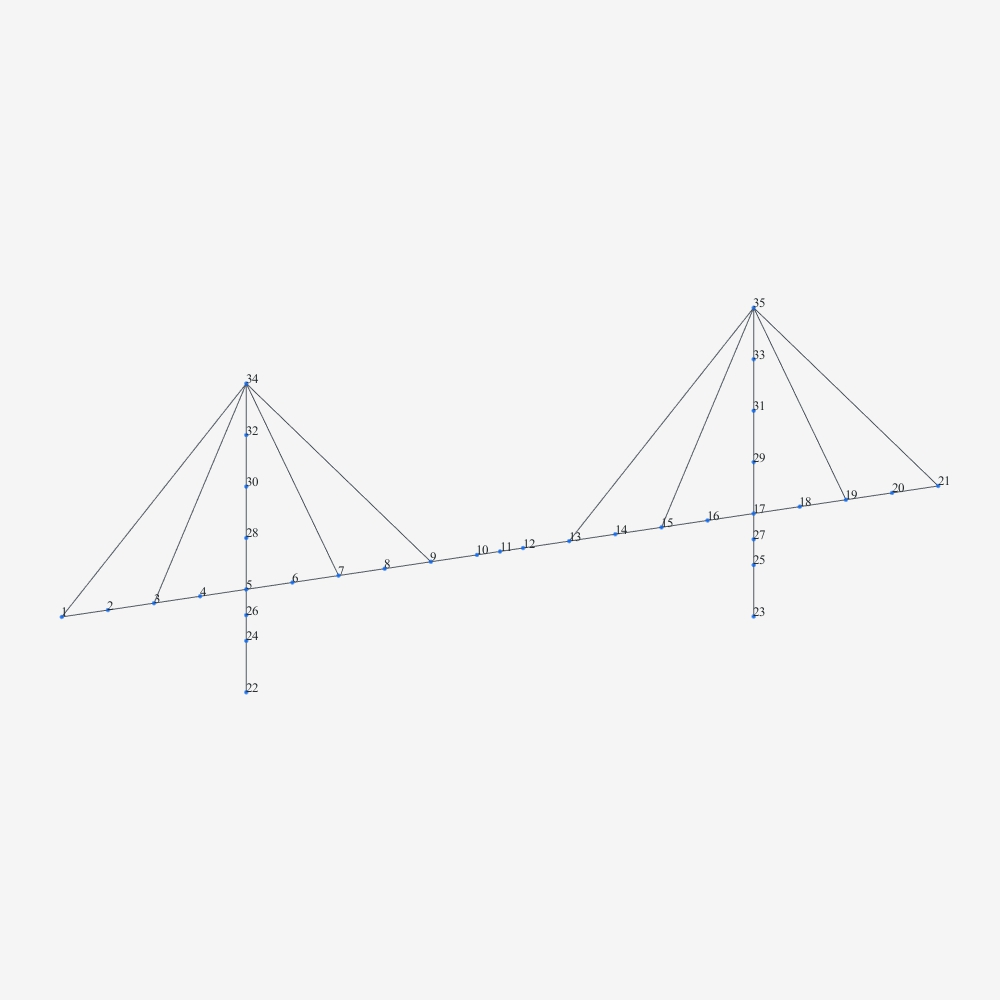

In [63]:
from IPython.display import Image

Image(filename="C:\\Program Files\\MIDAS\\midas Civil\\Tutorial\\api_res\\image.jpg")

### Display

`DISPLAY`

#### Thickness Color

`db/CO_T`

Get, Put

Inputs:

1. Wire Frame Red: `W_R` - Integer
2. Wire Frame Green: `W_G` - Integer
3. Wire Frame Blue: `W_B` - Integer
4. Hidden Fill Red: `HF_R` - Integer
5. Hidden Fill Green: `HF_G` - Integer
6. Hidden Fill Blue: `HF_B` - Integer
7. Hidden Edge Red: `HE_R` - Integer
8. Hidden Edge Green: `HE_G` - Integer
9. Hidden Edge Blue: `HE_B` - Integer
10. Opacity Boolean: `bBLEMD` - Boolean
    - if `bBLEMD` is `True`:
        - `FACT` - Real

In [64]:
thickness_color_data = {
    "Assign": {
        "1": {
            "W_R": 111,
            "W_G": 142,
            "W_B": 91,
            "HF_R": 159,
            "HF_G": 205,
            "HF_B": 131,
            "HE_R": 111,
            "HE_G": 142,
            "HE_B": 91,
            "bBLEMD": False,
            "FACT": 0.5,
        }
    }
}

In [65]:
MidasAPI("PUT", "db/CO_T", thickness_color_data)

PUT db/CO_T 200


{'CO_T': {'1': {'W_R': 111,
   'W_G': 142,
   'W_B': 91,
   'HF_R': 159,
   'HF_G': 205,
   'HF_B': 131,
   'HE_R': 111,
   'HE_G': 142,
   'HE_B': 91,
   'bBLEMD': False,
   'FACT': 0.5}}}

#### Material Color

`db/CO_M`

Get, Put

Inputs:

1. Wire Frame Red: `W_R` - Integer
2. Wire Frame Green: `W_G` - Integer
3. Wire Frame Blue: `W_B` - Integer
4. Hidden Fill Red: `HF_R` - Integer
5. Hidden Fill Green: `HF_G` - Integer
6. Hidden Fill Blue: `HF_B` - Integer
7. Hidden Edge Red: `HE_R` - Integer
8. Hidden Edge Green: `HE_G` - Integer
9. Hidden Edge Blue: `HE_B` - Integer
10. Opacity Boolean: `bBLEMD` - Boolean
    - if `bBLEMD` is `True`:
        - `FACT` - Real

In [66]:
MidasAPI("GET", "db/CO_M")

GET db/CO_M 200


{'CO_M': {'1': {'W_R': 255,
   'W_G': 0,
   'W_B': 0,
   'HF_R': 255,
   'HF_G': 77,
   'HF_B': 77,
   'HE_R': 192,
   'HE_G': 220,
   'HE_B': 192,
   'bBLEMD': False,
   'FACT': 0.5},
  '2': {'W_R': 255,
   'W_G': 0,
   'W_B': 0,
   'HF_R': 255,
   'HF_G': 77,
   'HF_B': 77,
   'HE_R': 192,
   'HE_G': 220,
   'HE_B': 192,
   'bBLEMD': False,
   'FACT': 0.5},
  '3': {'W_R': 255,
   'W_G': 0,
   'W_B': 0,
   'HF_R': 255,
   'HF_G': 77,
   'HF_B': 77,
   'HE_R': 192,
   'HE_G': 220,
   'HE_B': 192,
   'bBLEMD': False,
   'FACT': 0.5},
  '4': {'W_R': 255,
   'W_G': 0,
   'W_B': 0,
   'HF_R': 255,
   'HF_G': 77,
   'HF_B': 77,
   'HE_R': 192,
   'HE_G': 220,
   'HE_B': 192,
   'bBLEMD': False,
   'FACT': 0.5},
  '5': {'W_R': 255,
   'W_G': 0,
   'W_B': 0,
   'HF_R': 255,
   'HF_G': 77,
   'HF_B': 77,
   'HE_R': 192,
   'HE_G': 220,
   'HE_B': 192,
   'bBLEMD': False,
   'FACT': 0.5}}}

#### Floor Load Color

`db/co_f`

Get, Put

Inputs:

1. Floor Load Type Name: `NAME` - String
1. Wire Frame Red: `W_R` - Integer
2. Wire Frame Green: `W_G` - Integer
3. Wire Frame Blue: `W_B` - Integer
4. Hidden Fill Red: `HF_R` - Integer
5. Hidden Fill Green: `HF_G` - Integer
6. Hidden Fill Blue: `HF_B` - Integer
7. Hidden Edge Red: `HE_R` - Integer
8. Hidden Edge Green: `HE_G` - Integer
9. Hidden Edge Blue: `HE_B` - Integer
10. Blending: `OPT_BLEND` - Boolean
    - Blending Factor: `BLEND_FACTOR` - REAL

In [67]:
floor_load_color_data = {
    "Assign": {
        "1": {
            "NAME": "FL",
            "WF_R": 166,
            "WF_G": 202,
            "WF_B": 240,
            "HF_R": 166,
            "HF_G": 202,
            "HF_B": 240,
            "HE_R": 166,
            "HE_G": 202,
            "HE_B": 240,
            "OPT_BLEND": True,
            "BLEND_FACTOR": 0.25,
        }
    }
}

In [68]:
MidasAPI("PUT", "db/co_f", floor_load_color_data)

PUT db/co_f 200


{'CO_F': {'1': {'NAME': 'FL',
   'WF_R': 166,
   'WF_G': 202,
   'WF_B': 240,
   'HF_R': 166,
   'HF_G': 202,
   'HF_B': 240,
   'HE_R': 166,
   'HE_G': 202,
   'HE_B': 240,
   'OPT_BLEND': True,
   'BLEND_FACTOR': 0.25}}}

#### Section Color

`db/CO_S`

Get, Put

Inputs:

1. Wire Frame Red: `W_R` - Integer
2. Wire Frame Green: `W_G` - Integer
3. Wire Frame Blue: `W_B` - Integer
4. Hidden Fill Red: `HF_R` - Integer
5. Hidden Fill Green: `HF_G` - Integer
6. Hidden Fill Blue: `HF_B` - Integer
7. Hidden Edge Red: `HE_R` - Integer
8. Hidden Edge Green: `HE_G` - Integer
9. Hidden Edge Blue: `HE_B` - Integer
10. Blending: `bBLEMD` - Boolean
    - Blending Factor: `FACT` - REAL

In [69]:
MidasAPI("GET", "db/co_S")

GET db/co_S 200


{'CO_S': {'1': {'W_R': 255,
   'W_G': 0,
   'W_B': 0,
   'HF_R': 255,
   'HF_G': 77,
   'HF_B': 77,
   'HE_R': 192,
   'HE_G': 220,
   'HE_B': 192,
   'bBLEMD': False,
   'FACT': 0.5},
  '2': {'W_R': 255,
   'W_G': 0,
   'W_B': 0,
   'HF_R': 255,
   'HF_G': 77,
   'HF_B': 77,
   'HE_R': 192,
   'HE_G': 220,
   'HE_B': 192,
   'bBLEMD': False,
   'FACT': 0.5},
  '3': {'W_R': 255,
   'W_G': 0,
   'W_B': 0,
   'HF_R': 255,
   'HF_G': 77,
   'HF_B': 77,
   'HE_R': 192,
   'HE_G': 220,
   'HE_B': 192,
   'bBLEMD': False,
   'FACT': 0.5},
  '4': {'W_R': 255,
   'W_G': 0,
   'W_B': 0,
   'HF_R': 255,
   'HF_G': 77,
   'HF_B': 77,
   'HE_R': 192,
   'HE_G': 220,
   'HE_B': 192,
   'bBLEMD': False,
   'FACT': 0.5},
  '5': {'W_R': 255,
   'W_G': 0,
   'W_B': 0,
   'HF_R': 255,
   'HF_G': 77,
   'HF_B': 77,
   'HE_R': 192,
   'HE_G': 220,
   'HE_B': 192,
   'bBLEMD': False,
   'FACT': 0.5},
  '105': {'W_R': 111,
   'W_G': 142,
   'W_B': 91,
   'HF_R': 159,
   'HF_G': 205,
   'HF_B': 131,
   'HE_R

### Activations

#### Active

`VIEW/ACTIVE`

Post

Inputs:

1. Activate Mode Type: `ACTIVE_MODE` - String
    - `All` - Activate All
    - `Active` - Activate by Node/Element
        - Node Number List: `N_LIST` - Integer
        - Element Number List: `E_LIST` - Integer
    - `Identity` - Activate by Identity
        - Identity Type: `IDENTITY_TYPE` - String
            - Structure Group: `Group`
            - Named Plane: `Named Plane`
            - Load Group: `Load Group`
            - Boundary Group: `Boundary Group`
2. Identity List: `IDENTITY_LIST` - String

In [70]:
activate_all_data = {"Argument": {"ACTIVE_MODE": "Active"}}

activate_by_list_data = {
    "Argument": {
        "ACTIVE_MODE": "Active",
        "N_LIST": [1, 3, 7, 9, 34],
        "E_LIST": [33, 34, 35, 36],
    }
}

In [79]:
# //TODO - Seems to work, but results in 'error status' message
MidasAPI("POST", "view/active", activate_all_data)

POST view/active 200


{'message': 'error status'}

In [72]:
active_view_data = MidasAPI("GET", "view/active")

GET view/active 200


In [73]:
# //TODO - Determine why this is resulting in an error
MidasAPI("POST", "view/active", active_view_data)

POST view/active 200


{'message': "MIDAS CIVIL NX  It's failed, Parsing a request's body",
 'command': 'ACTIVE+='}

### Coordinate System

#### Named UCS

`db/NUCS`

Get, Post, Put, Delete

1. UCS Name: `NAME` - String
2. O (X, Y, Z): `ORG_ITEM` - Real
3. V (XX, XY, XZ): `VX_ITEM` - Real
4. V (YX, YY, YZ): `VY_ITEM` - Real

In [74]:
nucs_data = {
    "Assign": {
        "1": {
            "NAME": "UCS1",
            "ORG_ITEM": [0, 0, 0],
            "VX_ITEM": [1, 0, 0],
            "VY_ITEM": [0, 1, 0],
        }
    }
}

In [75]:
MidasAPI("PUT", "db/NUCS", nucs_data)

PUT db/NUCS 200


{'NUCS': {'1': {'NAME': 'UCS1',
   'ORG_ITEM': [0, 0, 0],
   'VX_ITEM': [1, 0, 0],
   'VY_ITEM': [0, 1, 0]}}}

# Structure

### PSC Bridge

#### Span

`db/span`

Get, Post, Put, Delete



In [76]:
span_data = {
    "Assign": {
        "1": {
            "NAME": "s1",
            "bEXACTSPAN": True,
            "DIRECTION": 0,
            "SECTTYPE": 0,
            "SPAN_LIST": [2.5, 5, 32.5],
            "SPAN_BASE_ITEMS": [
                {"ELEM_KEY": 1, "SUPPORT": 1},
                {"ELEM_KEY": 2, "SUPPORT": 1},
                {"ELEM_KEY": 3, "SUPPORT": 2},
                {"ELEM_KEY": 4, "SUPPORT": 0},
                {"ELEM_KEY": 5, "SUPPORT": 0},
                {"ELEM_KEY": 6, "SUPPORT": 0},
                {"ELEM_KEY": 7, "SUPPORT": 0},
                {"ELEM_KEY": 8, "SUPPORT": 0},
                {"ELEM_KEY": 9, "SUPPORT": 0},
                {"ELEM_KEY": 10, "SUPPORT": 0},
                {"ELEM_KEY": 11, "SUPPORT": 0},
                {"ELEM_KEY": 12, "SUPPORT": 0},
                {"ELEM_KEY": 13, "SUPPORT": 0},
                {"ELEM_KEY": 14, "SUPPORT": 0},
                {"ELEM_KEY": 15, "SUPPORT": 0},
                {"ELEM_KEY": 16, "SUPPORT": 2},
            ],
        }
    }
}

In [80]:
MidasAPI("PUT", "db/span", span_data)

PUT db/span 200


{'SPAN': {'1': {'NAME': 's1',
   'bEXACTSPAN': True,
   'DIRECTION': 0,
   'SECTTYPE': 0,
   'SPAN_LIST': [2.5, 5, 32.5],
   'SPAN_BASE_ITEMS': [{'ELEM_KEY': 1, 'SUPPORT': 1},
    {'ELEM_KEY': 2, 'SUPPORT': 1},
    {'ELEM_KEY': 3, 'SUPPORT': 2},
    {'ELEM_KEY': 4, 'SUPPORT': 0},
    {'ELEM_KEY': 5, 'SUPPORT': 0},
    {'ELEM_KEY': 6, 'SUPPORT': 0},
    {'ELEM_KEY': 7, 'SUPPORT': 0},
    {'ELEM_KEY': 8, 'SUPPORT': 0},
    {'ELEM_KEY': 9, 'SUPPORT': 0},
    {'ELEM_KEY': 10, 'SUPPORT': 0},
    {'ELEM_KEY': 11, 'SUPPORT': 0},
    {'ELEM_KEY': 12, 'SUPPORT': 0},
    {'ELEM_KEY': 13, 'SUPPORT': 0},
    {'ELEM_KEY': 14, 'SUPPORT': 0},
    {'ELEM_KEY': 15, 'SUPPORT': 0},
    {'ELEM_KEY': 16, 'SUPPORT': 2}]}}}

# Node/Element

### General

#### Node

`db/NODE`

Get, Post, Put, Delete

Input Data;

1. Node ID: - String
2. X Coordinate: `X` - Real
3. Y Coordinate: `Y` - Real
4. Z Coordinate: `Z` - Real

In [81]:
MidasAPI("GET", "db/node")

GET db/node 200


{'NODE': {'1': {'X': -311.6797900262467, 'Y': 0, 'Z': 0},
  '2': {'X': -278.87139107611546, 'Y': 0, 'Z': 0},
  '3': {'X': -246.06299212598424, 'Y': 0, 'Z': 0},
  '4': {'X': -213.25459317585305, 'Y': 0, 'Z': 0},
  '5': {'X': -180.44619422572177, 'Y': 0, 'Z': 0},
  '6': {'X': -147.63779527559055, 'Y': 0, 'Z': 0},
  '7': {'X': -114.82939632545931, 'Y': 0, 'Z': 0},
  '8': {'X': -82.02099737532808, 'Y': 0, 'Z': 0},
  '9': {'X': -49.212598425196845, 'Y': 0, 'Z': 0},
  '10': {'X': -16.404199475065617, 'Y': 0, 'Z': 0},
  '11': {'X': 0, 'Y': 0, 'Z': 0},
  '12': {'X': 16.404199475065617, 'Y': 0, 'Z': 0},
  '13': {'X': 49.212598425196845, 'Y': 0, 'Z': 0},
  '14': {'X': 82.02099737532808, 'Y': 0, 'Z': 0},
  '15': {'X': 114.82939632545931, 'Y': 0, 'Z': 0},
  '16': {'X': 147.63779527559055, 'Y': 0, 'Z': 0},
  '17': {'X': 180.44619422572177, 'Y': 0, 'Z': 0},
  '18': {'X': 213.25459317585305, 'Y': 0, 'Z': 0},
  '19': {'X': 246.06299212598424, 'Y': 0, 'Z': 0},
  '20': {'X': 278.87139107611546, 'Y': 0, 

#### Element

`db/ELEM`

Inputs:

1. Element Number: - String
2. Element Type: `Type` - String
3. Material No.: `MATL` - Integer
4. Section / Thickness No.: `SECT` - Integer
5. Node No.: `NODE` - Integer
6. Beta Angle: `ANGLE` - Real
7. Element Subtype: `STYPE` - Integer
8. Local Axis: `LCAXIS` - Integer

Required Input data for defining Create Element (Tension Only/Hook/Cable Type Only)

**Truss (Tension Only)**
1. Allow. Comp.: `TENS` - Real
2. Tension Limit Value: `T_LIMIT` - Real
3. Tension Limit: `T_bLMT` - Boolean

**Hook**
1. Hook Length: `NON_LEN` - Real

**Cable**
1. Cable Type: `CABLE` - Integer
    - Pretension: 1
    - Horizontal: 2
    - Lu: 3
2. Pretension/Horizontal: `TENS` - Real
3. Lu: `NON_LEN` - Real

Required Input data for defining Create Element (Compression only/Gap Type only)
**Truss Compression Only**
1. Allow. Tens.: `TENS` - Real
2. Compression Limit: `T_bLMT` - Boolean
3. Compression Limit Value: `T_LIMIT` - Real

**Gap**
1. Gap: `NON_LEN` - Real

The required Input Data for defining Create Element (Wall Type Only) [MIDAS GEN only]  

**Wall**
1. Wall ID: `WALL` - Integer
2. Orientation (Wall Beta Angle Only): `W_CON` - Integer
   - Beta Angle: 0
   - Ref Point: 1
   - Ref Vector: 2
3. Wall Type: `W_TYPE` - Integer
   - Plate base: 0
   - CRB - Pin: 1
   - CRB - Fixed: 2

Allowed `TYPE` Values (# of Nodes required) `-` = Subtype Values:


`BEAM` (2): General Beam/Tapered Beam  
`TRUSS` (2): Truss  
`TENSTR` (2): Tension only/Hook/Cable  
    - Truss: 1
    - Hook:  2
    - Cable: 3  
`COMPTR` (2): Compression only/Gap  
    - Truss: 1
    - Gap:   2  
`PLATE` (4): Plate  
    - Thick: 1
    - Thin:  2
    - Thick with Drilling DOF: 3  
    - Thin with Drilling DOF:  4  
`WALL` (4): Wall (MIDAS GEN ONLY)  
    - Membrane: 1  
    - Plate: 2  
`PLSTRS` (4): Plane Stress
    - w/ Drilling DOF Inactive: 1
    - w/ Drilling DOF Active: 2
`PLSTRN` (4): Plane Strain  
`AXISYM` (4): Axisymmetric  
`SOLID` (8): Solid

In [82]:
MidasAPI("GET", "db/elem")

GET db/elem 200


{'ELEM': {'1': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [1, 2, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '2': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [2, 3, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '3': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [3, 4, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '4': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [4, 5, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '5': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [5, 6, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '6': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [6, 7, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '7': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [7, 8, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '8': {'TYPE': 'BEAM',
   'MATL': 1,
   'SECT': 1,
   'NODE': [8, 9, 0, 0, 0, 0, 0, 0],
   'ANGLE': 0,
   'STYPE': 0},
  '9': {'TYPE': 'BEAM',
   'MATL

### Node Detail

#### Node Local Axis

`SKEW`

Inputs:

1. Method: `iMETHOD` - Integer
    1. Angle - `1`:
       - about x: `ANGLE_X` - Real
       - about y: `ANGLE_Y` - Real
       - about z: `ANGLE_Z` - Real
    2. 3 Points - `2`:
       - P0 Coordinate - X: `P0X` - Real
       - P0 Coordinate - Y: `P0Y` - Real
       - P0 Coordinate - Z: `P0Z` - Real
       - P1 Coordinate - X: `P1X` - Real
       - P1 Coordinate - Y: `P1Y` - Real
       - P1 Coordinate - Z: `P1Z` - Real
       - P2 Coordinate - X: `P2X` - Real
       - P2 Coordinate - Y: `P2Y` - Real
       - P2 Coordinate - Z: `P2Z` - Real
    3. Vector - `3`:
       - Direction Vector V1-X: `V1X` - Real
       - Direction Vector V1-Y: `V1Y` - Real
       - Direction Vector V1-Z: `V1Z` - Real
       - Direction Vector V2-X: `V1X` - Real
       - Direction Vector V2-Y: `V1Y` - Real
       - Direction Vector V2-Z: `V1Z` - Real
    4. Line Vector - `4`:
       - Direction Vector V0-X: `LV0X` - Real
       - Direction Vector V0-X: `LV0Y` - Real
       - Direction Vector V0-X: `LV0Z` - Real
       - Direction Vector V1-X: `LV1X` - Real
       - Direction Vector V1-X: `LV1Y` - Real
       - Direction Vector V1-X: `LV1Z` - Real
       - Direction Vector V2-X: `LV2X` - Real
       - Direction Vector V2-X: `LV2Y` - Real
       - Direction Vector V2-X: `LV2Z` - Real
2. Reference Type: `REFTYPE` - Integer
    - 1: Ref. Point, Required P0, P1 Point
    - 2: Global Direction, Required P0 Point
3. Global Direction: `G_DIR` - Integer
    - 0: Global X
    - 1: Global Y
    - 2: Global Z
4. Local Direction: `L_DIR` - Integer
    - 0: Local X
    - 1: Local Y
    - 2: Local Z

In [83]:
# //TODO - Doesn't seem like a call that should have a 'GET'
MidasAPI("GET", "db/SKEW")

GET db/SKEW 404


{'error': {'message': 'result is empty'}}

### Element Detail

#### Element Weight Table

`post/table`

Post Only

Inputs;

1. Table Name (Output Title): `TABLE_NAME` - String
2. Result Table Type: `TABLE_TYPE` - String
3. Result Table Save Path (JSON Format): `EXPORT_PATH` - String
4. Node / Element No. Input: `NODE_ELEMS`
   - Method 1 - Keys: `KEYS` - Integer
   - Method 2 - Range: `TO` - String
   - Method 3 - Structure Group Name: `STRUCTURE_GROUP_NAME` - String

In [84]:
element_weight_data = {
    "Argument": {
        "TABLE_NAME": "Python Example",
        "TABLE_TYPE": "ELEMENTWEIGHT",
        "EXPORT_PATH": "C:\\Program Files\\MIDAS\\midas Civil\\Tutorial\\api_res\\table_example.json",
        "NODE_ELEMS": {"TO": "1 to 5"},
    }
}

In [85]:
MidasAPI("POST", "POST/Table", element_weight_data)

POST POST/Table 200


{'PythonExample': {'FORCE': 'kips',
  'DIST': 'ft',
  'HEAD': ['Index',
   'No',
   'Type',
   'No',
   'Name',
   'No',
   'Name',
   'No',
   'Name',
   'Type',
   'Value',
   'Unit Weight',
   'Total Weight'],
  'DATA': [['1',
    '1',
    'BEAM',
    '1',
    'CABLE',
    '1',
    'CABLE',
    '-',
    '-',
    'L',
    '32.8084',
    '0.4907',
    '0.9012'],
   ['2',
    '2',
    'BEAM',
    '1',
    'CABLE',
    '1',
    'CABLE',
    '-',
    '-',
    'L',
    '32.8084',
    '0.4907',
    '0.9012'],
   ['3',
    '3',
    'BEAM',
    '1',
    'CABLE',
    '1',
    'CABLE',
    '-',
    '-',
    'L',
    '32.8084',
    '0.4907',
    '0.9012'],
   ['4',
    '4',
    'BEAM',
    '1',
    'CABLE',
    '1',
    'CABLE',
    '-',
    '-',
    'L',
    '32.8084',
    '0.4907',
    '0.9012'],
   ['5',
    '5',
    'BEAM',
    '1',
    'CABLE',
    '1',
    'CABLE',
    '-',
    '-',
    'L',
    '32.8084',
    '0.4907',
    '0.9012']]}}

### Mesh

#### Define Domain

`db/MADO`

Get, Post, Put, Delete

Inputs:

1. Domain No.: - String
2. Domain Name: `NAME` - String
3. Element Type: `TYPE` - Integer
    - Plate: `4`
    - Plane Stress: `3`
    - Plane Strain: `6`
    - Axisymmetric: `7`
4. Element Material: `MATL` - Integer
5. Elemenet Property: `PROP` - Integer
6. Sub Type: `SUB_TYPE` - Integer

In [86]:
domain_data = {
    "Assign": {"1": {"NAME": "DM1", "TYPE": 4, "MATL": 0, "PROP": 0, "SUB_TYPE": 2}}
}

In [87]:
MidasAPI("POST", "db/MADO", domain_data)

POST db/MADO 400


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

#### Define Sub-Domain

`db/SBDO`

Get, Post, Put, Delete

Inputs:

1. Sub Domain No.: - String
2. Sub Domain Name: `SUB_DOMAIN_NAME` - String
3. Member Type: `MEMBER_TYPE` - Integer (Gen Only)
    - None: `0`
    - Slab: `1`
    - Mat: `2`
4. Member Type Civil: `MEMB_TYPE_CIVIL` - Integer (Civil Only)
    - None: `0`
    - Plate Beam(1D): `1`
    - Plate Column(1D): `2`
    - Shell: `3`
5. Rebar Dir. 1: `V1` - Real
6. Rebar Dir. 2: `V2` - Real
7. Domain Name: `DOMAIN_NAME` - String
8. Use Mt: `bUseMt` - Boolean
9. Thickness: `THICKNESS` - Real
10. Rebar Direction: `REBAR_AXIS_TYPE` - Integer (CIVIL Only)
    - Local: `0`
    - UCS: `1`
        - UCS: `STR_UCS` - String (if rebar direction is UCS)
    - Reference Axis: `2`
        - Axis Vector: `AXIS_VECTOR` - Real (if rebar direction is Reference Axis)
11. Basic Rebar Boolean: `OPT_BASIC_REBAR` - Boolean (GEN Only - See Doc for parameters)

In [ ]:
sub_domain_data = {
    "Assign": {
        "1": {
            "SUB_DOMAIN_NAME": "SDM1",
            "MEMBER_TYPE": 1,
            "V1": 0,
            "V2": 90,
            "DOMAIN_NAME": "DM1",
            "AXIS_VECTOR": [0, 0, 0, 0, 0, 0],
            "bUseMt": True,
            "STR_UCS": "",
            "MEMB_TYPE_CIVIL": 1,
        }
    }
}

In [ ]:
MidasAPI("POST", "db/SBDO", sub_domain_data)

#### Domain-Element

\# //TODO - Figure out what this is for

`db/DOEL`

Get, Post, Put, Delete

Inputs:

1. Element No.: - String
2. Domain Type: `Type` - Integer
    - Main-Domain: 0
    - Sub-Domain: 1
3. Key Domain: `KEY_DOMAIN` - Integer
4. Main Domain Name: `MAIN_DOMAIN_NAME` - String

In [88]:
domain_element_data = {
    "Assign": {
        "35": {"TYPE": 1, "KEY_DOMAIN": 1, "MAIN_DOMAIN_NAME": "DM1"},
        "34": {"TYPE": 1, "KEY_DOMAIN": 1, "MAIN_DOMAIN_NAME": "DM1"},
        "33": {"TYPE": 0, "KEY_DOMAIN": 1, "MAIN_DOMAIN_NAME": "DM1"},
        "32": {"TYPE": 0, "KEY_DOMAIN": 1, "MAIN_DOMAIN_NAME": "DM1"},
        "31": {"TYPE": 0, "KEY_DOMAIN": 1, "MAIN_DOMAIN_NAME": "DM1"},
        "30": {"TYPE": 0, "KEY_DOMAIN": 1, "MAIN_DOMAIN_NAME": "DM1"},
    }
}

In [89]:
MidasAPI("post", "db/DOEL", domain_element_data)

post db/DOEL 201


{'DOEL': {'30': {'TYPE': 0, 'KEY_DOMAIN': 1, 'MAIN_DOMAIN_NAME': 'DM1'},
  '31': {'TYPE': 0, 'KEY_DOMAIN': 1, 'MAIN_DOMAIN_NAME': 'DM1'},
  '32': {'TYPE': 0, 'KEY_DOMAIN': 1, 'MAIN_DOMAIN_NAME': 'DM1'},
  '33': {'TYPE': 0, 'KEY_DOMAIN': 1, 'MAIN_DOMAIN_NAME': 'DM1'},
  '34': {'TYPE': 1, 'KEY_DOMAIN': 1, 'MAIN_DOMAIN_NAME': 'DM1'},
  '35': {'TYPE': 1, 'KEY_DOMAIN': 1, 'MAIN_DOMAIN_NAME': 'DM1'}}}

# Properties

## Material Properties

### Material Properties

#### Material Data

`db/MATL`

#### Inelastic Material Properties for Fiber Model

`db/IMFM`

### Time Dependent

#### User Define

`db/TDMF`

Get, Post, Put, Delete

#### Creep/Shrinkage

`db/TDMT`

Get, Post, Put, Delete

#### Compressive Strength

`db/TDME`

Get, Post, Put, Delete

### Change Property

`db/EDMP`

Get, Post, Put, Delete

### Material Link

`db/TMAT`

Get, Post, Put, Delete

### Plastic Material

`db/EPMT`

Get, Post, Put, Delete

## Section Properties

### Section Properties (Common)

#### DB/USER

`db/SECT`

Get, Post, Put, Delete

\# //TODO - This function is probably 99% of what future functions will build on

inputs:

1. Common Key:
2. Section Data - Before: `SECT_BEFORE` - Object
    - Data Type: `DATATYPE` - Integer
        - DB: `1`
        - User: `2`
    - Section I: `SECT_I` - Object
        - DB Name: `DB_Name` - String
            - Section Data Base
        - Section Name of DB: `SECT_NAME` - String
            - Section Data Base
        - Dimension of Section: `vSIZE` - Array [Real]
        - Stiffness for Design: `CF_STIFF_ULS` - Object
            - Effective Area: `A_EFF` - Real
            - Net Area: `A_NET` - Real
            - Moment of Inertia; y-axis: `LY_EFF` - Real
            - Moment of Inertia; z-axis: `LZ_EFF` - Real
            - Section Modulus; y-axis: `WY_EFF` - Real
            - Section Modulus; z-axis: `WZ_EFF` - Real
            - Torsional Moment of Inertia: `LT_EFF` - Real
            - Warping Moment of Inertia: `LW_EFF` - Real
            - Radius of Gyration; y-axis: `RY_EFF` - Real
            - Radius of Gyration; z-axis: `RZ_EFF` - Real
        - Stiffeners
            - Number of Stiffeners 1: `CELL_SHAPE` - Integer
                - Box with Stiffener: `N1`
                - Pipe with Stiffener: `N`
            - Number of Stiffeners 2: `CELL_TYPE` - Integer
                - Box with Stiffener: `N2`
3. Coating Thickness for Design (GEN Only): `COAT_THIK` - Real
4. Type of Forming for Design (GEN Only): `FORM_TYPE` - Integer
    - Roll Forming: `0`
    - Other Methods of Forming: `1`

<b><center>Dimension Table for User Sections</center></b>

| Index/Shape | 0 | 1  | 2  |  3  |  4  |  5  |  6  | 7   |  8  |  9  |
|:-----------:|:-:|:--:|:--:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|      L      | H | B  | tw | tf  |  -  |  -  |  -  |  -  |  -  |  -  |
|      C      | H | B1 | tw | tf1 | B2  | tf2 |  -  |  -  |  -  |  -  |
|      H      | H | B1 | tw | tf1 | B2  | tf2 | r1  | r2  |  -  |  -  |
|      T      | H | B  | tw | tf  |  -  |  -  |  -  |  -  |  -  |  -  |
|      B      | H | B  | tw | tf1 |  C  | tf2 |  -  |  -  |  -  |  -  |
|      P      | P | tw | -  |  -  |  -  |  -  |  -  |  -  |  -  |  -  |
|     2L      | H | B  | tw | tf  |  C  |  -  |  -  |  -  |  -  |  -  |
|     2C      | H | B  | tw | tf  |  C  |  -  |  -  |  -  |  -  |  -  |
|     SB      | H | B  | -  |  -  |  -  |  -  |  -  |  -  |  -  |  -  |
|     SR      | D | -  | -  |  -  |  -  |  -  |  -  |  -  |  -  |  -  |
|     OCT     | H | B  | a  |  b  |  t  |  -  |  -  |  -  |  -  |  -  |
|    SOCT     | H | B  | a  |  b  |  -  |  -  |  -  |  -  |  -  |  -  |
|    ROCT     | H | B  | a  |  b  | t1  | t2  | t3  |  -  |  -  |  -  |
|     TRK     | H | B  | t  |  -  |  -  |  -  |  -  |  -  |  -  |  -  |
|    STRK     | H | B  | -  |  -  |  -  |  -  |  -  |  -  |  -  |  -  |
|    HTRK     | H | B  | -  |  -  |  -  |  -  |  -  |  -  |  -  |  -  |
|     CL      | H | B  | tw | tf  |  C  |  -  |  -  |  -  |  -  |  -  |
|     CC      | H | B  | tw |  r  |  d  |  -  |  -  |  -  |  -  |  -  |
|     UP      | H | B  | tw | Hw1 | Hw2 | B1  | B2  | B3  | Bf3 |  d  |
|      Z      | H | B  | tw |  r  |  d  | th  |  -  |  -  |  -  |  -  |
|    URIB     | H | B1 | B2 |  t  |  R  |  -  |  -  |  -  |  -  |  -  |
|    BSTF     | H | B  | tf | tw  | S1  | Hr1 | tr1 | S2  | Hr2 | tr2 |
|    PSTF     | D | tw | Hr | tr  |  -  |  -  |  -  |  -  |  -  |  -  |
|     UDT     | H | B1 | b2 | tw  | tf  |  -  |  -  |  -  |  -  |  -  |


In [90]:
section_builder_data = {
    "Assign": {
        "1": {
            "SECTTYPE": "AISC10(US)",
            "SECT_NAME": "L8X8X1",
            "SECT_BEFORE": {
                "OFFSET_PT": "CC",
                "OFFSET_CENTER": 0,
                "USER_OFFSET_REF": 0,
                "HORZ_OFFSET_OPT": 0,
                "USERDEF_OFFSET_YI": 0,
                "VERT_OFFSET_OPT": 0,
                "USERDEF_OFFSET_ZI": 0,
                "USE_SHEAR_DEFORM": True,
                "USE_WARPING_EFFECT": True,
                "SHAPE": "L",
                "DATATYPE": 1,
                "SECT_I": {"DB_NAME": "AISC10(US)", "SECT_NAME": "L8X8X1"},
            },
        }
    }
}

temp_sections = MidasAPI("GET", "db/sect")

temp_sections["SECT"]["1"] = section_builder_data["Assign"]["1"]

GET db/sect 200


In [91]:
temp_sections["Assign"] = temp_sections.pop("SECT")

In [92]:
temp_sections

{'Assign': {'1': {'SECTTYPE': 'AISC10(US)',
   'SECT_NAME': 'L8X8X1',
   'SECT_BEFORE': {'OFFSET_PT': 'CC',
    'OFFSET_CENTER': 0,
    'USER_OFFSET_REF': 0,
    'HORZ_OFFSET_OPT': 0,
    'USERDEF_OFFSET_YI': 0,
    'VERT_OFFSET_OPT': 0,
    'USERDEF_OFFSET_ZI': 0,
    'USE_SHEAR_DEFORM': True,
    'USE_WARPING_EFFECT': True,
    'SHAPE': 'L',
    'DATATYPE': 1,
    'SECT_I': {'DB_NAME': 'AISC10(US)', 'SECT_NAME': 'L8X8X1'}}},
  '2': {'SECTTYPE': 'VALUE',
   'SECT_NAME': 'GIRDER',
   'SECT_BEFORE': {'OFFSET_PT': 'CC',
    'OFFSET_CENTER': 0,
    'USER_OFFSET_REF': 0,
    'HORZ_OFFSET_OPT': 0,
    'USERDEF_OFFSET_YI': 0,
    'VERT_OFFSET_OPT': 0,
    'USERDEF_OFFSET_ZI': 0,
    'USE_SHEAR_DEFORM': True,
    'USE_WARPING_EFFECT': False,
    'SHAPE': 'SB',
    'SECT_I': {'vSIZE': [0, 0, 0, 0, 0, 0, 0, 0],
     'PERIIN': 0,
     'PERIOUT': 0,
     'BUILT_FLAG': 1,
     'STIFF': {'AREA': 3.3282011008466457,
      'ASY': 0,
      'ASZ': 0,
      'RXX': 0.8110323722126643,
      'RYY': 18.271

#### Value

`db/sect`

Get, Post, Put, Delete

inputs:

1. Common Key:
2. Calculation Options: `CALC_OPT` - Boolean
    - When True:
        - Automatically Calcs Sectional Properties
        - If Sectional Properties are already set, these are prioritized
    - When False:
        - Follows the inputted sectional properties, and if None, defaults are entered
3. Section Data - Before: `SECT_BEFORE` - Object
    - Section I: `SECT_I` - Object
        1. Dimension of Section: `vSIZE` - Array [Real]
        2. Built-Up Section Check: `BUILT_FLAG` - Integer
            - Not Built-up: `0`
            - Built-up: `1`
        3. Inside Perimeter Length of a Hollow Section: `PERIIN` - Real
        4. Total perimeter of the section: `PERIOUT` - Real
        5. Section Stiffness: `STIFF` - Object
            1. Cross Section Area: `AREA` - Real
            2. Effective Shear Area for Shear force in the element's local y-direction: `ASY` - Real
            3. Effective Shear Area for shear force in the element's local z-direction: `ASZ` - Real
            4. Torsional constant about the element's local x-axis: `RXX` - Real
            5. Moment of Inertia about the element's local y-direction: `RYY` - Real
            6. Moment of Inertia about the element's local z-direction: `RZZ` - Real
            7. Distance from the section's neutral axis to the extreme fiber of the element in the local (+)y-direction: `CYP` - Real
            8. Distance from the section's neutral axis to the extreme fiber of the element in the local (-)y-direction: `CYM` - Real
            9. Distance from the section's neutral axis to the extreme fiber of the element in the local (+)z-direction: `CZP` - Real
            10. Distance from the section's neutral axis to the extreme fiber of the element in the local (-)z-direction: `CZM` - Real
            11. Shear Coefficient for the shear force applied in the element's local z-direction: `QYB` - Real
            12. Shear Coefficient for the shear force applied in the element's local y-direction: `QZB` - Real
            13. Distance from the section's neutral axis to the Location 1,2,3,4: `Y` - Array[Real]
                - [y1, y2, y3, y4]
            14. Distance from the section's neutral axis to the Location 1,2,3,4: `Z` - Array[Real]
                - [z1, z2, z3, z4]
            15. Warping Constant: `Iw` - Real
            16. Warping Function: `W` - Array[Real]
                - [w1, w2, w3, w4]
            17. Coefficients to be used to calculate twisting and warping moment: `CXY` - Array[Real]
                - [Cxy1, Cxy2, Cxy3, Cxy4]
            18. Coefficients to be used to calculate twisting and warping moment: `CXZ` - Array[Real]
                - [Cxz1, Cxz2, Cxz3, Cxz4]
            19. Distance between centroid and shear center in the local y directions: `YS_YC` - Real
            20. Distance between centroid and shear center in the local z directions: `ZS_ZC` - Real
            21. Polar Moment of Inertia: `IP` - Real
        6. Section Stiffness for Design: `DESIGN` - Object
            1. Centroidal distance in ECS y-axis: `YBAR` - Real
            2. Centroidal distance in ECS z-axis: `ZBAR` - Real
            3. Plastic Section Modulus about the element local y-direction: `ZYY` - Real
            4. Plastic Section Modulus about the element local z-direction: `ZZZ` - Real
        7. Number of Cell: `CELL_SHAPE` - Integer (Additional Input - R-Octagon Only)

In [93]:
manual_channel_data = {
    "Assign": {
        "105": {
            "SECTTYPE": "VALUE",
            "SECT_NAME": "Channel_Manual",
            "CALC_OPT": False,
            "SECT_BEFORE": {
                "OFFSET_PT": "CC",
                "OFFSET_CENTER": 0,
                "USER_OFFSET_REF": 0,
                "HORZ_OFFSET_OPT": 0,
                "USERDEF_OFFSET_YI": 0,
                "VERT_OFFSET_OPT": 0,
                "USERDEF_OFFSET_ZI": 0,
                "USE_SHEAR_DEFORM": True,
                "USE_WARPING_EFFECT": True,
                "SHAPE": "C",
                "SECT_I": {
                    "vSIZE": [0.8, 0.7, 0.02, 0.03, 0.9, 0.04, 0, 0],
                    "BUILT_FLAG": 1,
                    "STIFF": {"AREA": 1000},
                },
            },
        }
    }
}

In [95]:
MidasAPI("PUT", "db/sect", manual_channel_data)

PUT db/sect 200


{'SECT': {'105': {'SECTTYPE': 'VALUE',
   'SECT_NAME': 'Channel_Manual',
   'CALC_OPT': False,
   'SECT_BEFORE': {'OFFSET_PT': 'CC',
    'OFFSET_CENTER': 0,
    'USER_OFFSET_REF': 0,
    'HORZ_OFFSET_OPT': 0,
    'USERDEF_OFFSET_YI': 0,
    'VERT_OFFSET_OPT': 0,
    'USERDEF_OFFSET_ZI': 0,
    'USE_SHEAR_DEFORM': True,
    'USE_WARPING_EFFECT': True,
    'SHAPE': 'C',
    'SECT_I': {'vSIZE': [0.8, 0.7, 0.02, 0.03, 0.9, 0.04, 0, 0],
     'BUILT_FLAG': 1,
     'STIFF': {'AREA': 1000}}}}}}

#### SRC

`db/sect`

Get, Post, Put, Delete

### Show Calculation Results

`ope/SECTPROP`

Get

## Thickness

## Tapered Group

## Section Manager

## Effective Width